# Quels tendancent on les variables ?

In [30]:
import csv
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Charger les données d'entrainement

In [2]:
df_train = pd.read_csv("data/train.csv")

ids = df_train["ID"]
target = df_train["TARGET"]
features = df_train.drop(columns=["TARGET", "ID"], errors='ignore').copy()

## On va mettre à l'échelle les données

In [3]:
def clean_special_codes(df):
    df = df.copy()
    max_dict = df.max().to_dict()

    for col in df.columns:
        data = df[col]

        # Remplacer les NaN
        data = data.fillna(-1)

        max_val = max_dict[col]

        if max_val in [9, 99, 999]:
            # Valeurs "non réponse"
            data = data.replace(max_val, -1)

            # Valeurs "jamais fait / non concerné"
            if max_val == 9:
                data = data.replace([8, 7], 0)
            elif max_val == 99:
                data = data.replace([88, 77], 0)
            elif max_val == 999:
                data = data.replace([888, 777], 0)

        df[col] = data

    return df

features = clean_special_codes(features)


### Conversion des poids en pounds

In [4]:
def clean_weight_to_lbs(series):
    series = series.copy()

    # Codes spéciaux
    series = series.replace({7777: 0, 9999: -1})

    # Cas 1 : poids déjà en livres
    lbs_mask = (series >= 1) & (series < 9000)

    # Cas 2 : poids en kg
    kg_mask = (series >= 9000) & (series < 9400)
    series.loc[kg_mask] = (series.loc[kg_mask] - 9000) * 2.20462  # conversion kg → lbs

    # Autres valeurs → NaN
    series.loc[~(lbs_mask | kg_mask)] = np.nan

    # Arrondir et convertir
    series = series.round().astype("Int64")

    return series

# Application
features["WEIGHT2"] = clean_weight_to_lbs(features["WEIGHT2"])

### Conversion des tailles en cm

In [5]:
def clean_height_to_cm(series, min_cm=50, max_cm=250):
    series = series.copy()

    # Codes spéciaux → NaN
    series = series.replace({7777: np.nan, 9999: np.nan})

    # Cas 1 : pieds/inches (200–711)
    ft_in_mask = (series >= 200) & (series <= 711)
    ft = series[ft_in_mask] // 100
    inch = series[ft_in_mask] % 100
    series.loc[ft_in_mask] = ft * 30.48 + inch * 2.54  # conversion en cm

    # Cas 2 : métrique (9000–9998)
    metric_mask = (series >= 9000) & (series <= 9998)
    series.loc[metric_mask] = series.loc[metric_mask] - 9000  # obtenir la valeur en cm

    # Arrondir et convertir en Int64
    series = series.round().astype("Int64")

    # Filtrer les tailles absurdes
    series.loc[(series < min_cm) | (series > max_cm)] = pd.NA

    return series

# Application
features["HEIGHT3"] = clean_height_to_cm(features["HEIGHT3"])

In [6]:
features_nan = features.isna().sum(axis = 0) / len(features)
print(features_nan)

_STATE      0.0
FMONTH      0.0
IDATE       0.0
IMONTH      0.0
IDAY        0.0
           ... 
_DRNKWK2    0.0
_RFDRHV8    0.0
_FLSHOT7    0.0
_PNEUMO3    0.0
_AIDTST4    0.0
Length: 323, dtype: float64


Voici les colones qu'on voudrait utiliser pour analyser les données d'entrainement. 

In [8]:
columns_of_interest = ['SEXVAR', 'GENHLTH', 'PHYSHLTH', 'MENTHLTH', 'POORHLTH', 'PRIMINSR', 'PERSDOC3', 'MEDCOST1', 'CHECKUP1', 'EXERANY2', 'SLEPTIM1', 'LASTDEN4', 'CVDSTRK3', 'ASTHMA3', 'ASTHNOW', 'CHCSCNC1', 'CHCOCNC1', 'CHCCOPD3', 'ADDEPEV3', 'CHCKDNY2', 'HAVARTH4', 'DIABETE4', 'WEIGHT2', 'HEIGHT3', 'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON', 'SMOKE100', 'SMOKDAY2', 'USENOW3', 'ECIGNOW2', 'LCSFIRST', 'LCSLAST', 'LCSNUMCG', 'ALCDAY4', 'AVEDRNK3', 'DRNK3GE5', 'MAXDRNKS', 'FLUSHOT7', 'HIVRISK5', 'COVIDPOS', 'COVIDSMP', 'COVIDPRM', 'PDIABTS1', 'PREDIAB2', 'DIABTYPE', 'INSULIN1', 'CHKHEMO3', 'EYEEXAM1', 'FEETSORE', 'TOLDCFS', 'HAVECFS', 'WORKCFS', 'COVIDVA1', 'SHINGLE2', 'COPDCOGH', 'COPDFLEM', 'COPDBRTH', 'COPDBTST', 'COPDSMOK', 'CNCRDIFF', 'CNCRAGE', 'CNCRTYP2', 'CSRVDOC1', 'CIMEMLOS', 'CDHOUSE', 'CDASSIST', 'CDHELP', 'CDSOCIAL', 'ACEDEPRS', 'ACEDRINK', 'ACEDRUGS', 'ACEPRISN', 'ACEPUNCH', 'LSATISFY', 'EMTSUPRT', 'SDHISOLT', 'SDHEMPLY', 'FOODSTMP', 'SDHFOOD1', 'SDHSTRE1', 'MARIJAN1', 'MARJSMOK']

In [9]:
from CRS.html_parser import parse_html

parsed, parsed_dict = parse_html(filename="USCODE22_LLCP_102523.HTML")
parsed_dict["HEIGHT3"]="Reported Height in cm"



 working directory
/Users/thomas/SDD/mini-hackaton



opening file ...
File read

File parsed



In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_hist(col, features, target, parsed_dict=None, bins=50, xmin=None, xmax=None, ymax=None):
    """
    Affiche deux histogrammes côte à côte pour une colonne, séparés par TARGET.

    Args:
        col (str): nom de la colonne
        features (pd.DataFrame): DataFrame des features
        target (pd.Series): série TARGET
        parsed_dict (dict, optional): dictionnaire {col: nom_lisible}
        bins (int): nombre de bins pour l'histogramme
        xmin (float, optional): limite min de l'axe x
        xmax (float, optional): limite max de l'axe x
        ymax (float, optional): limite max de l'axe y (%)
    """
    data = features[col]
    target_clean = target.loc[data.index]

    # Exclure les valeurs 0 et -1
    mask_valid = (data != 0) & (data != -1)
    data = data[mask_valid]
    target_clean = target_clean[mask_valid]

    # Séparer selon la cible
    data_0 = data[target_clean == 0]
    data_1 = data[target_clean == 1]

    # Créer la figure
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    title = parsed_dict[col] if parsed_dict is not None else col
    fig.suptitle(title, fontsize=12)

    # Histogramme TARGET = 0
    axes[0].hist(
        data_0,
        bins=bins,
        weights=np.ones(len(data_0)) / len(data_0) * 100,
        alpha=0.7,
        color="steelblue"
    )
    axes[0].set_title("Had no heart attack or diseases (TARGET = 0)")
    axes[0].set_xlabel(col)
    axes[0].set_ylabel("Fréquence (%)")
    if xmin is not None or xmax is not None:
        axes[0].set_xlim(left=xmin, right=xmax)
    if ymax is not None:
        axes[0].set_ylim(0, ymax)

    # Histogramme TARGET = 1
    axes[1].hist(
        data_1,
        bins=bins,
        weights=np.ones(len(data_1)) / len(data_1) * 100,
        alpha=0.7,
        color="darkorange"
    )
    axes[1].set_title("Had an heart attack or diseases (TARGET = 1)")
    axes[1].set_xlabel(col)
    axes[1].set_ylabel("Fréquence (%)")
    if xmin is not None or xmax is not None:
        axes[1].set_xlim(left=xmin, right=xmax)
    if ymax is not None:
        axes[1].set_ylim(0, ymax)

    plt.tight_layout()
    plt.show()


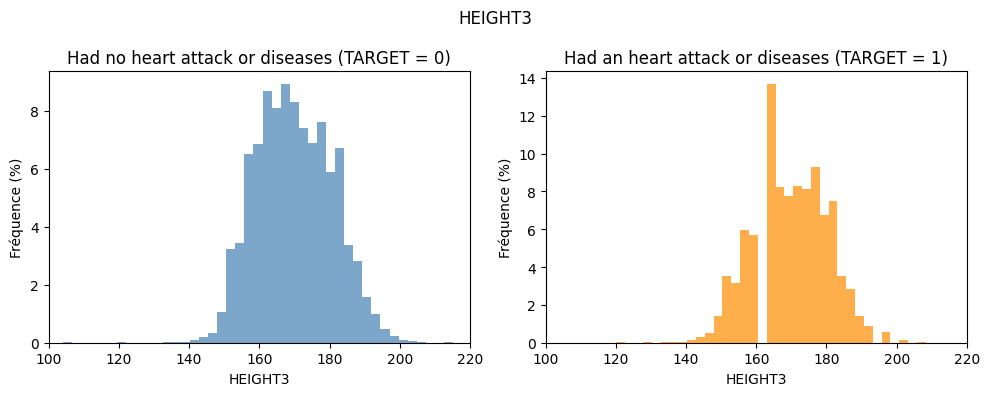

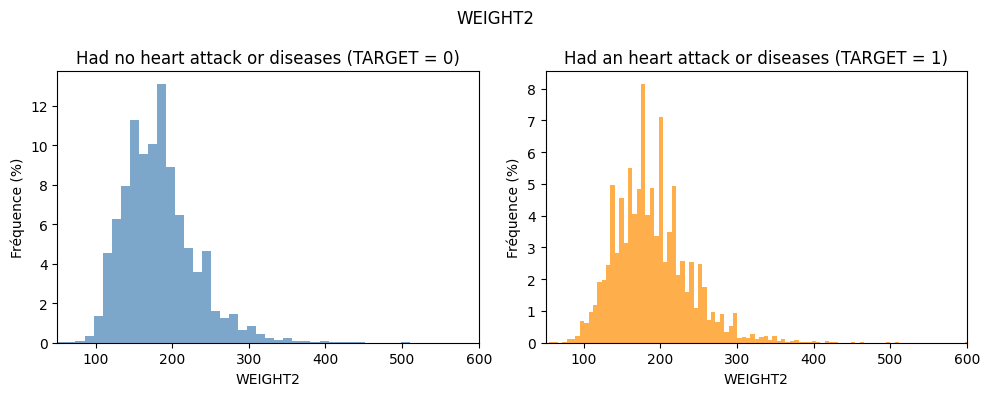

In [28]:
plot_hist("HEIGHT3", features, target,bins=60,xmin=100,xmax=220)
plot_hist("WEIGHT2", features, target,bins=100,xmin=50,xmax=600)

### Tout les plots des fréquences d'apparitions de chaques variables selon la target

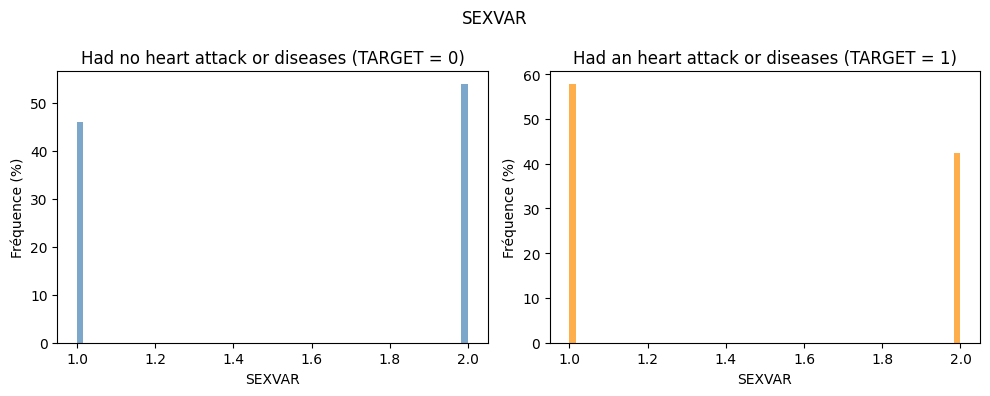

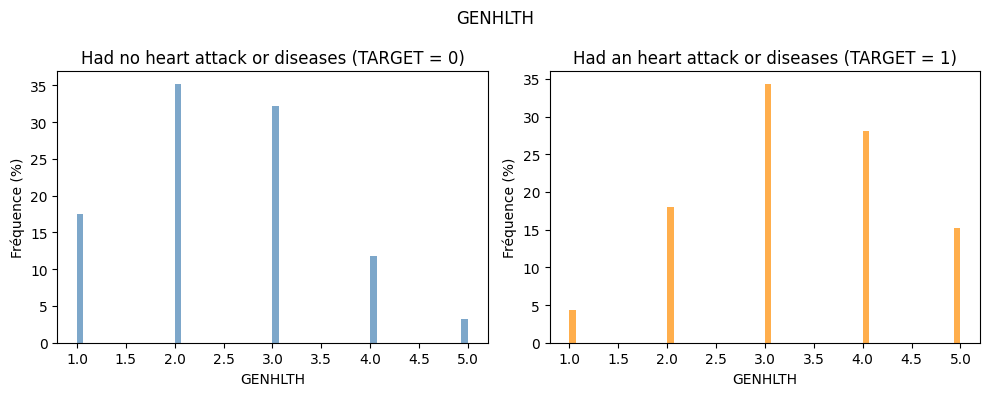

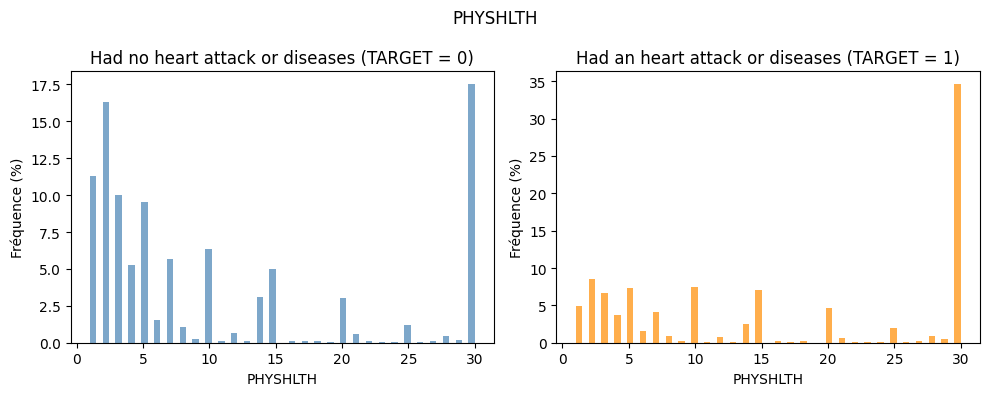

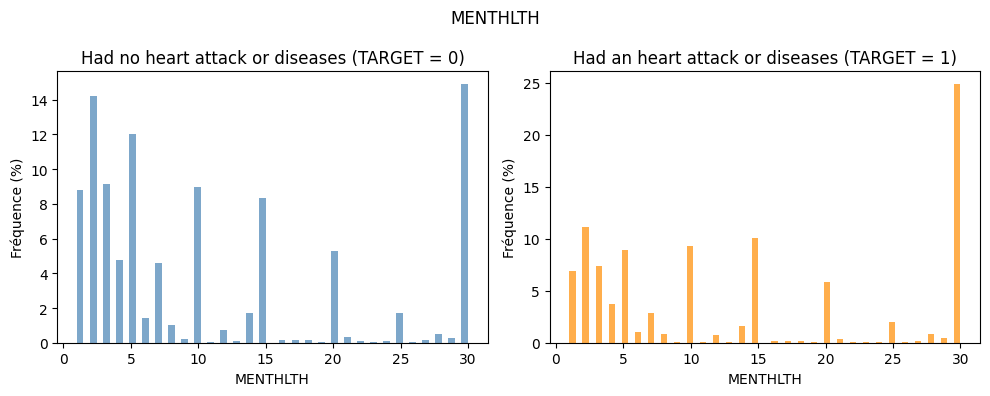

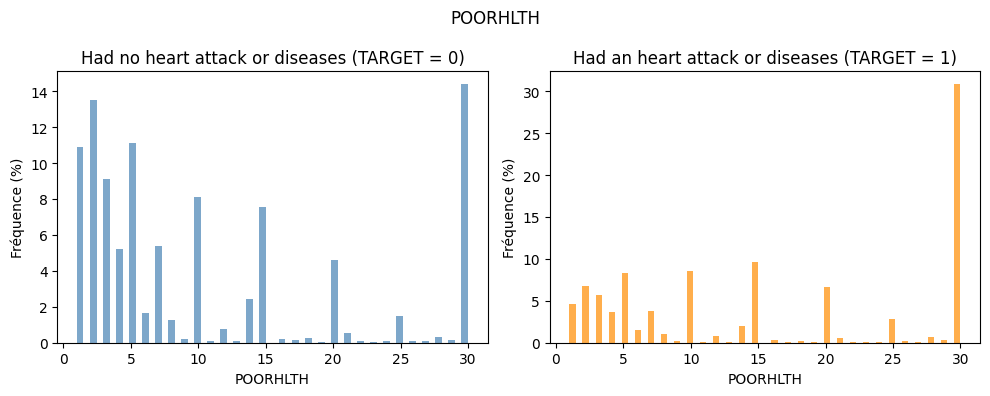

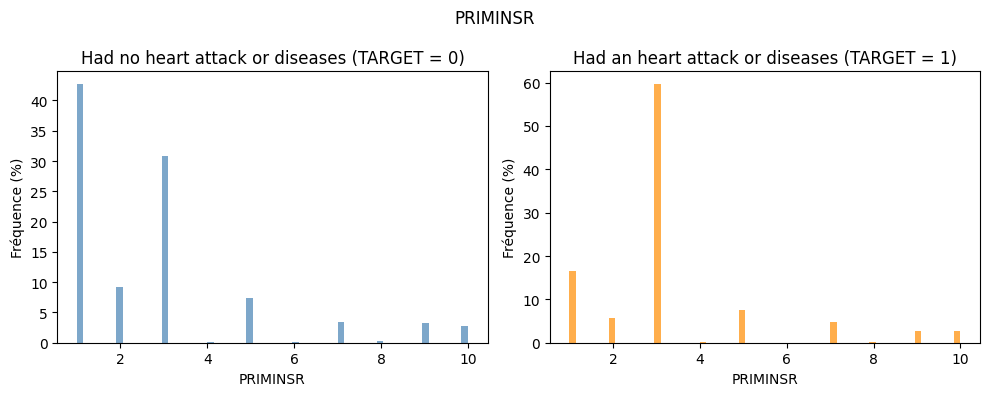

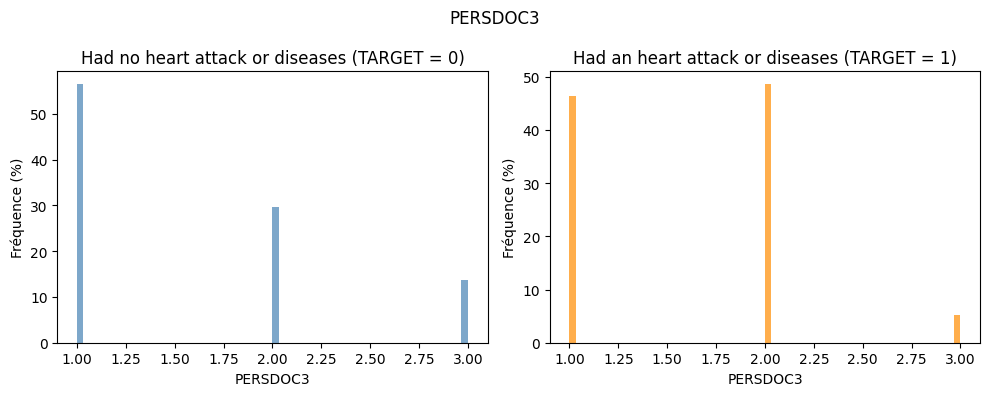

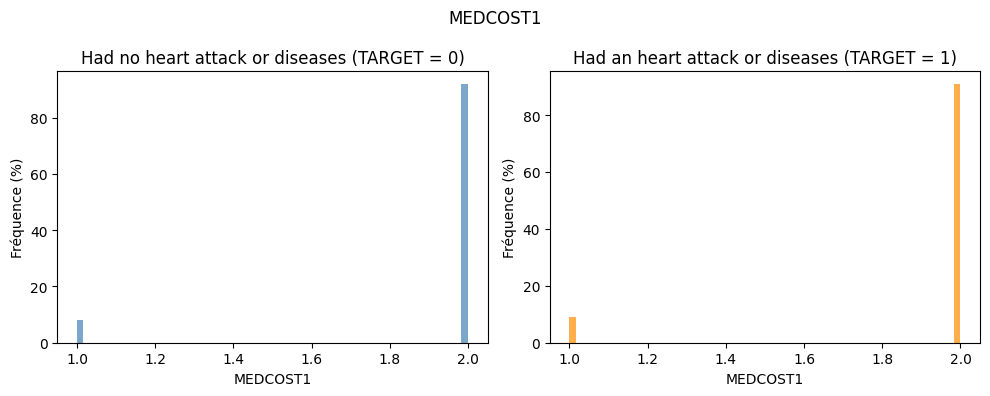

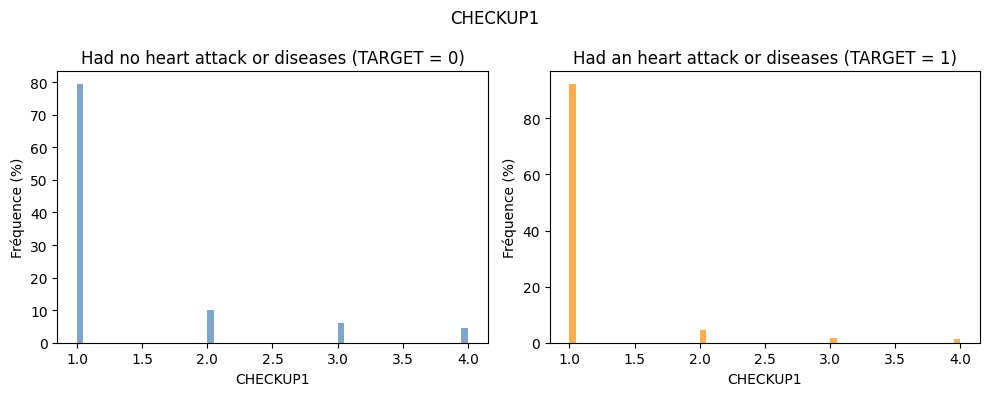

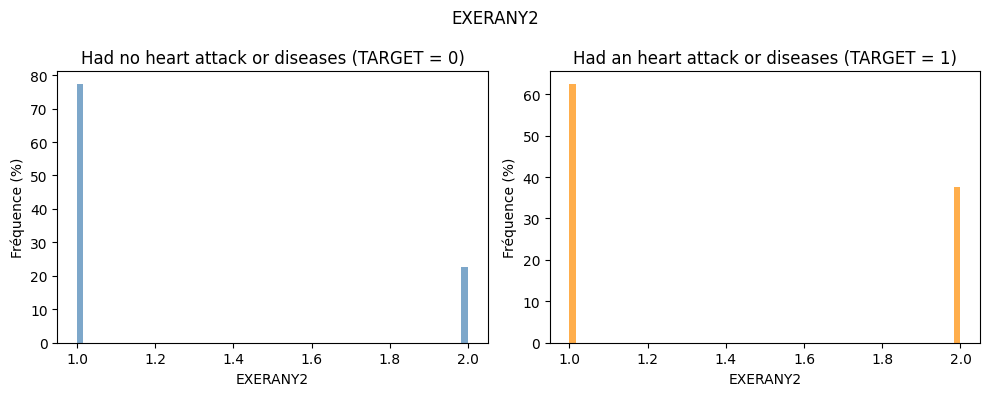

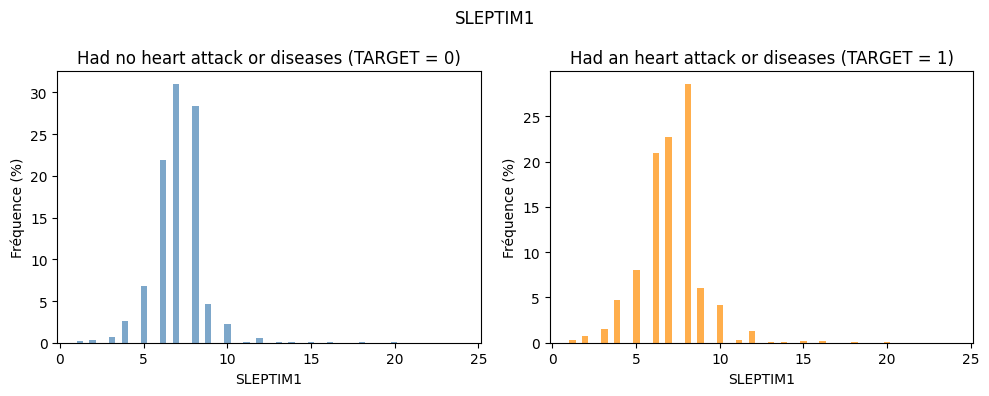

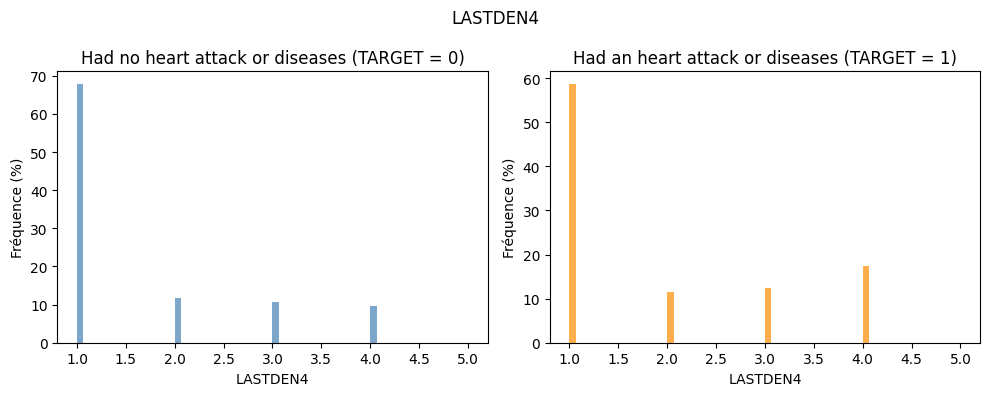

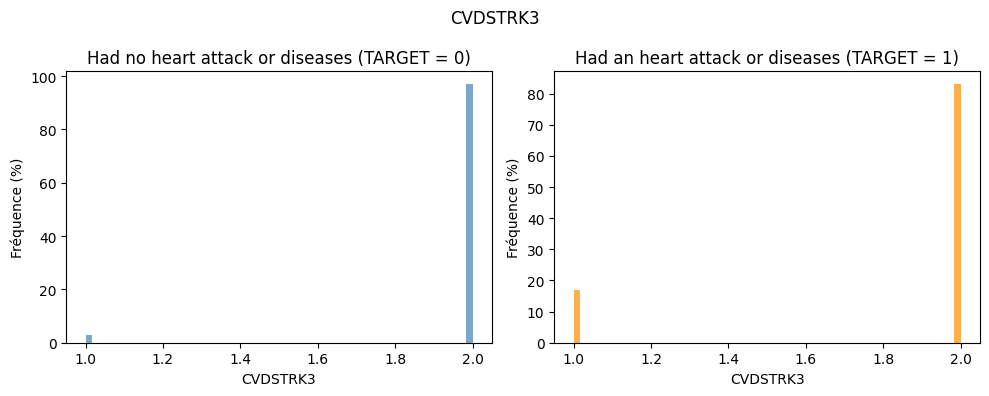

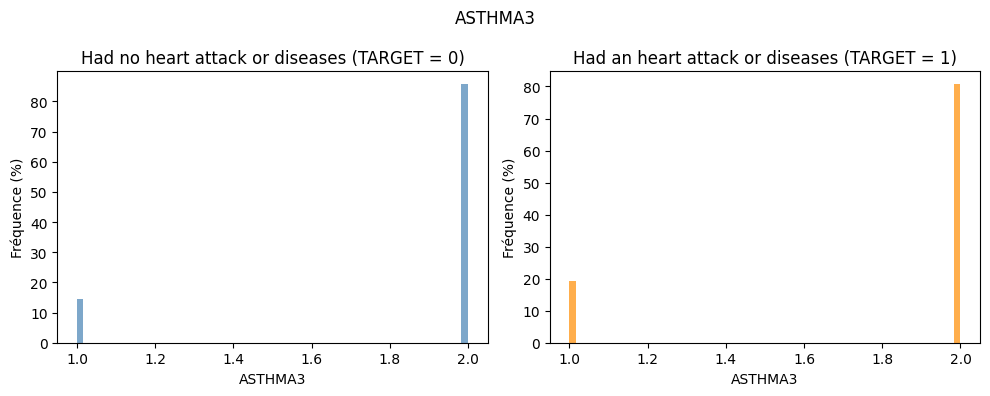

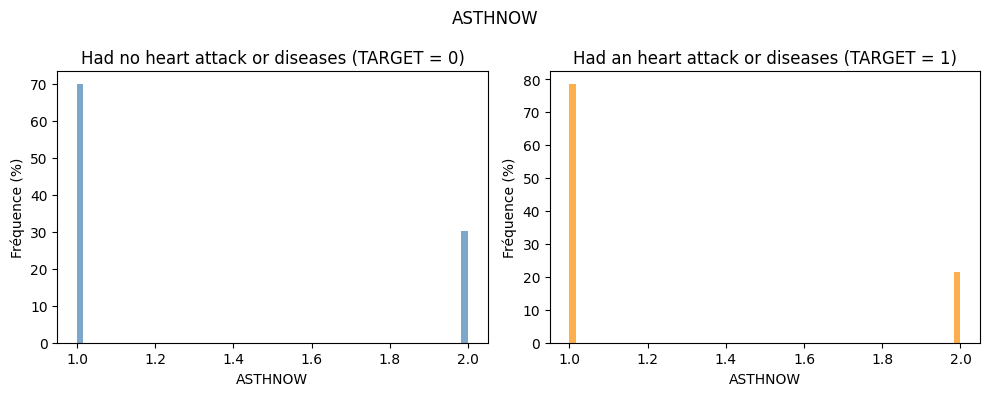

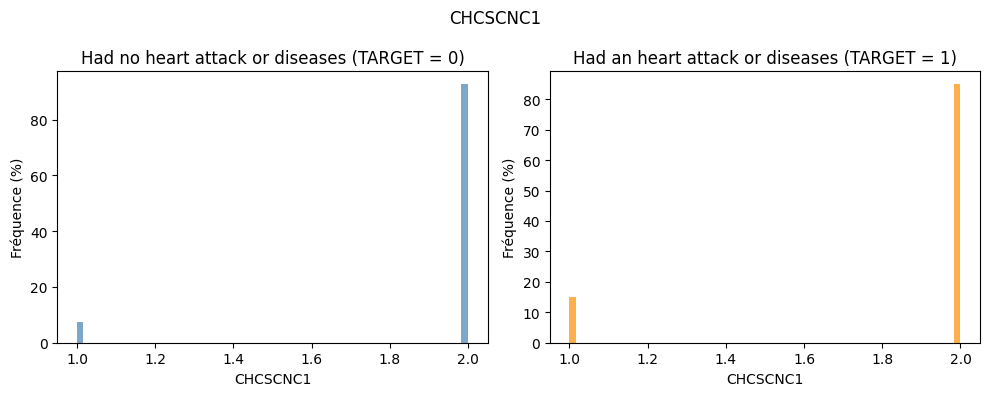

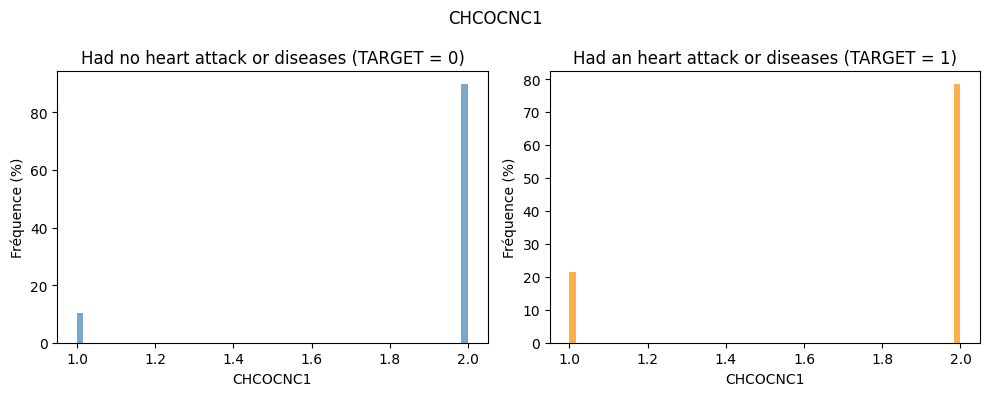

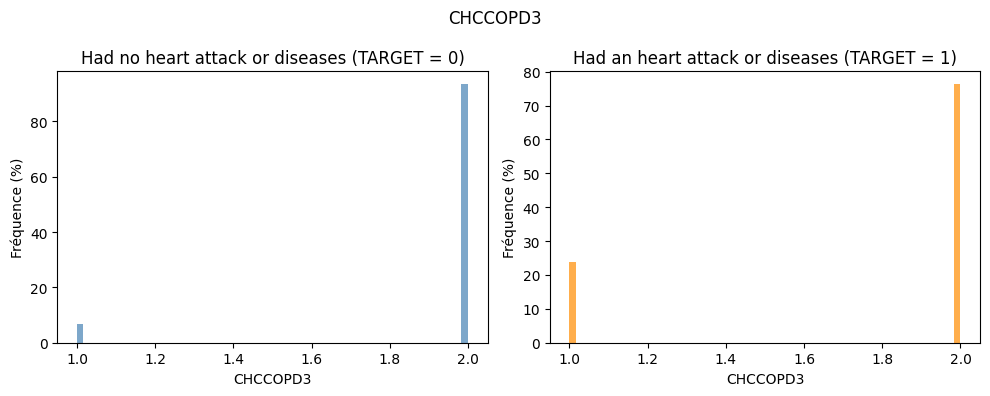

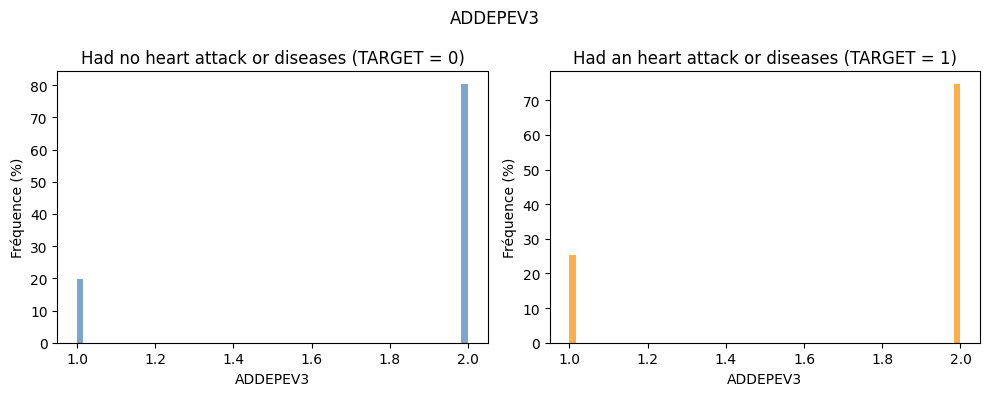

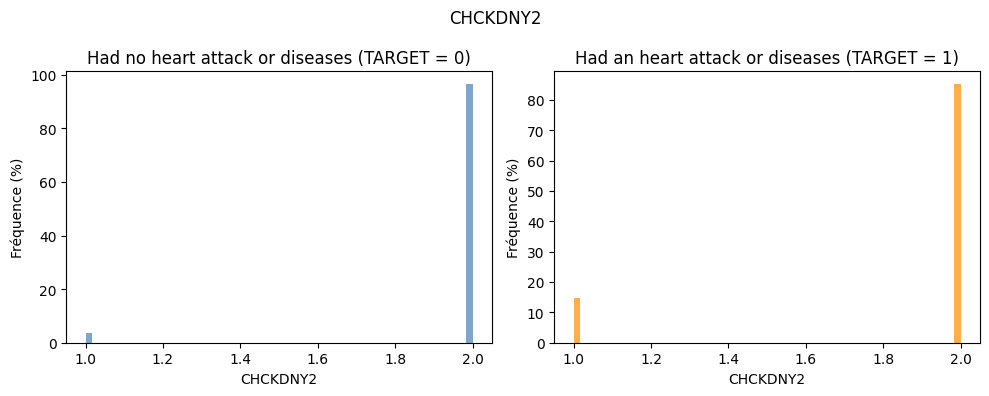

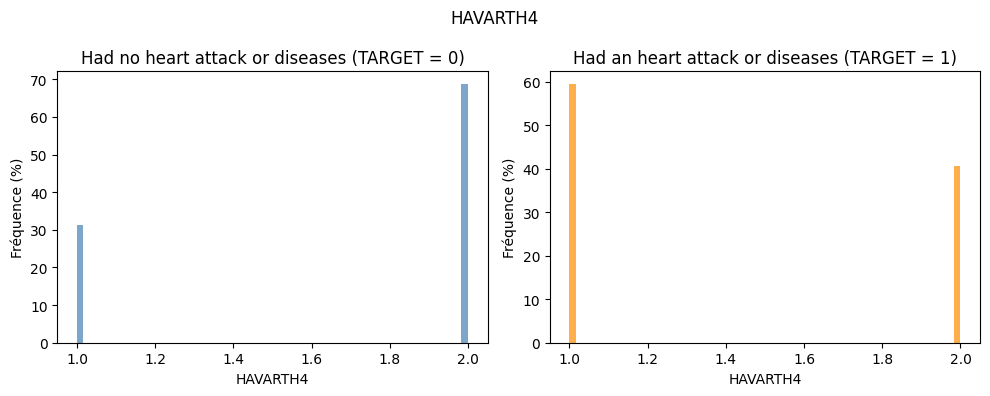

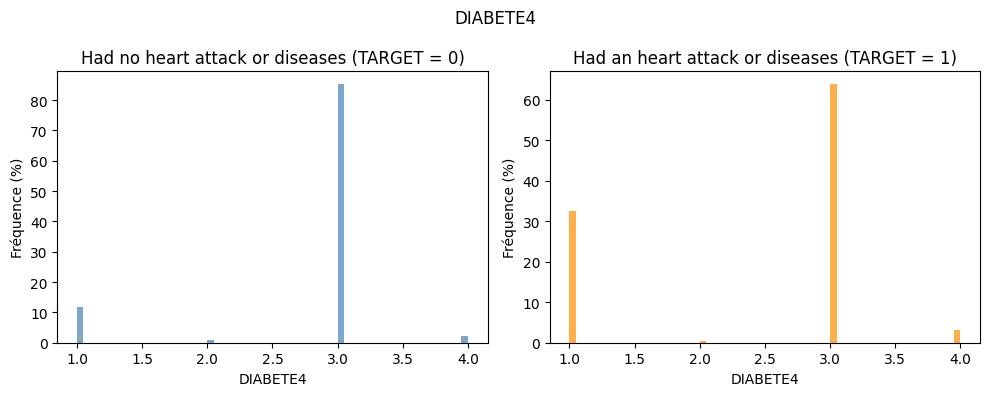

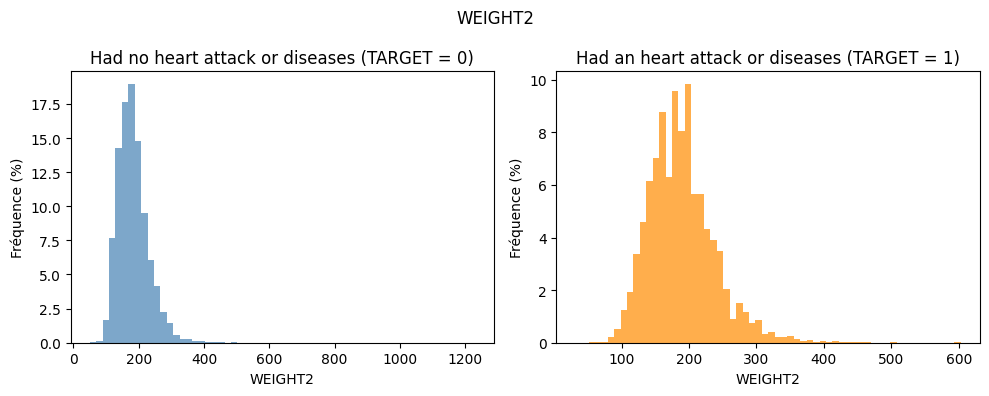

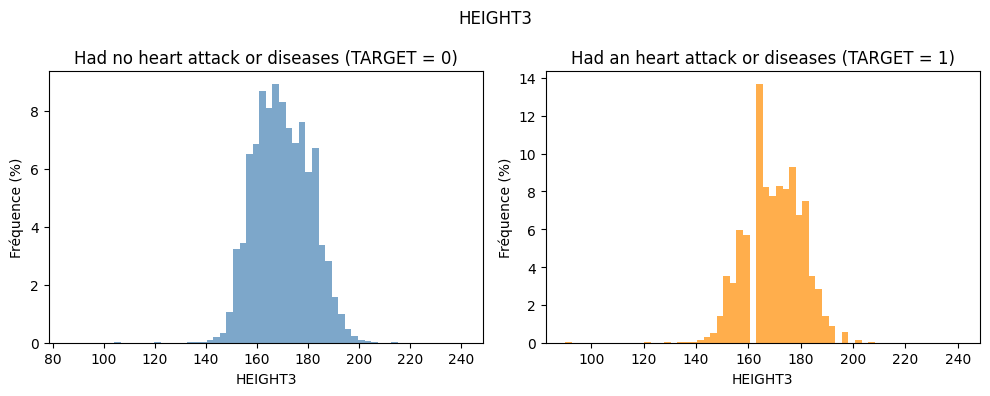

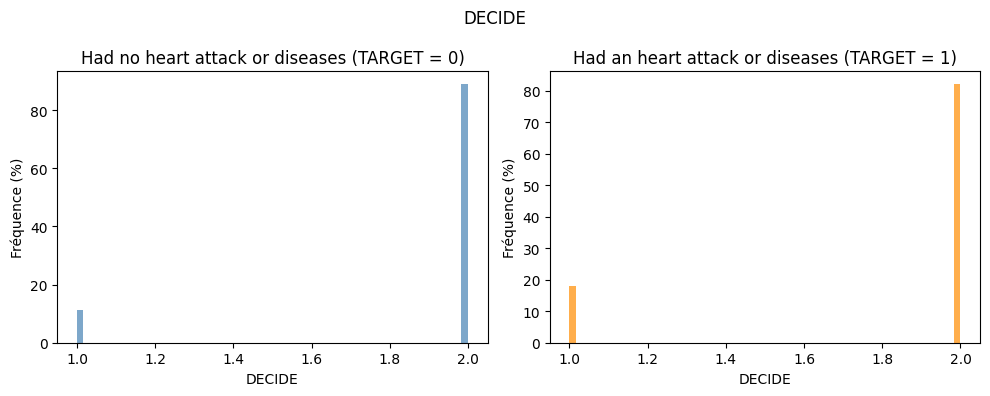

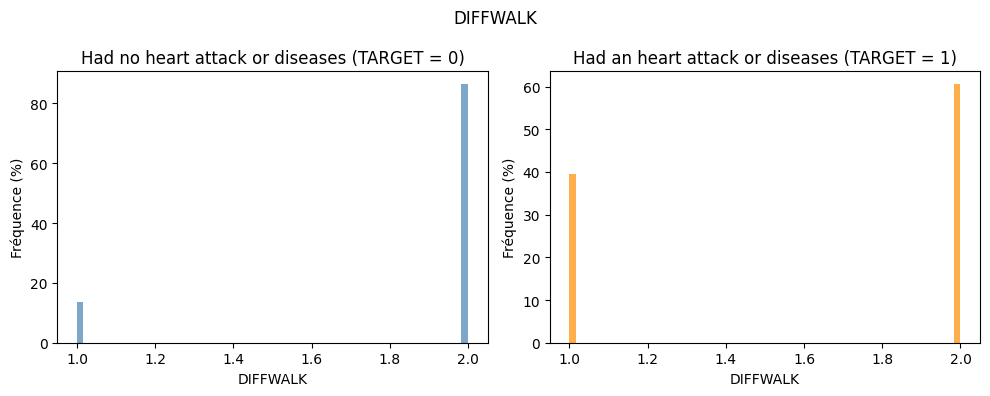

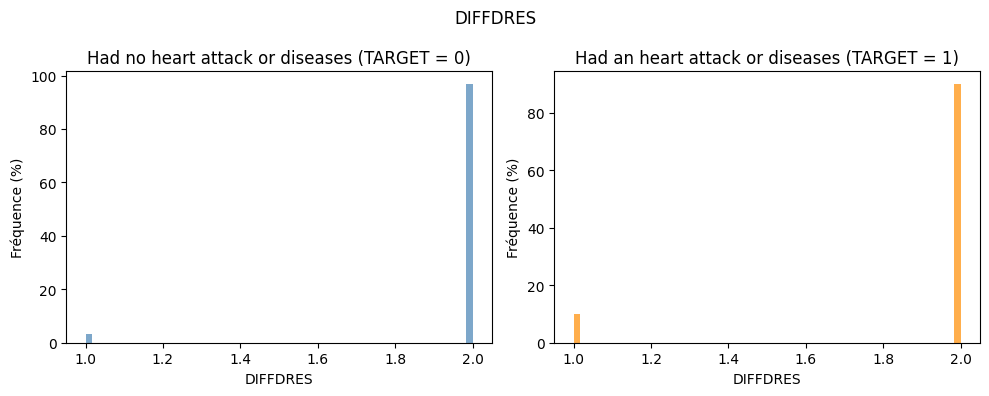

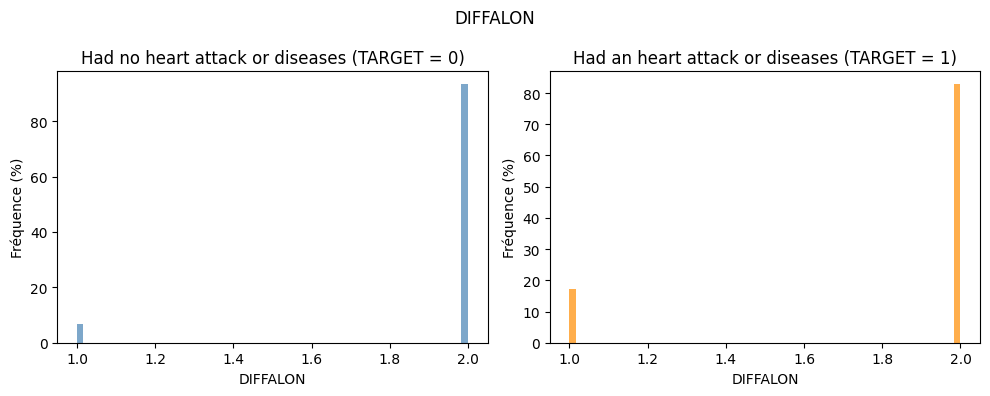

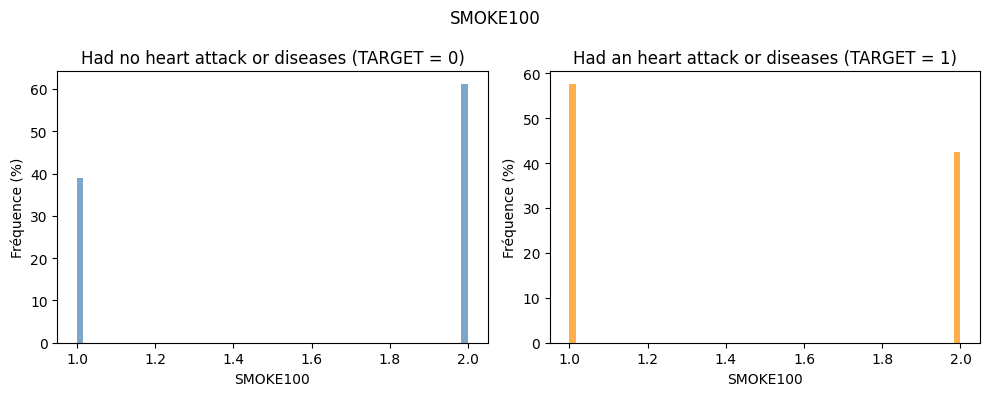

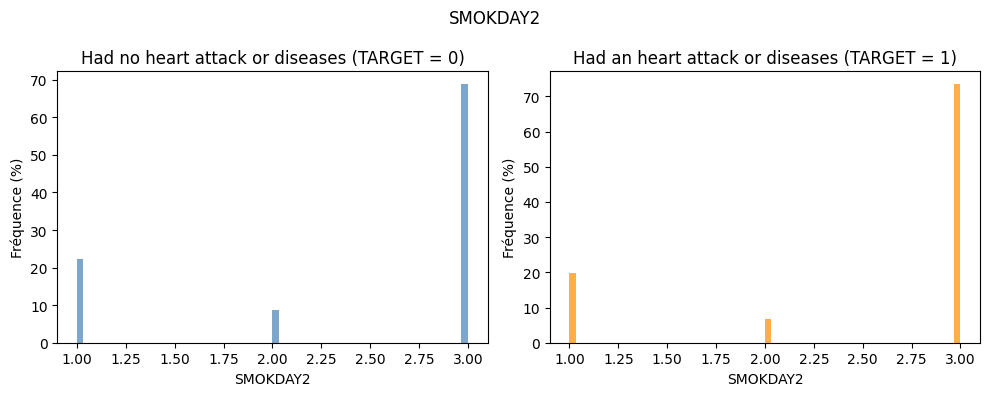

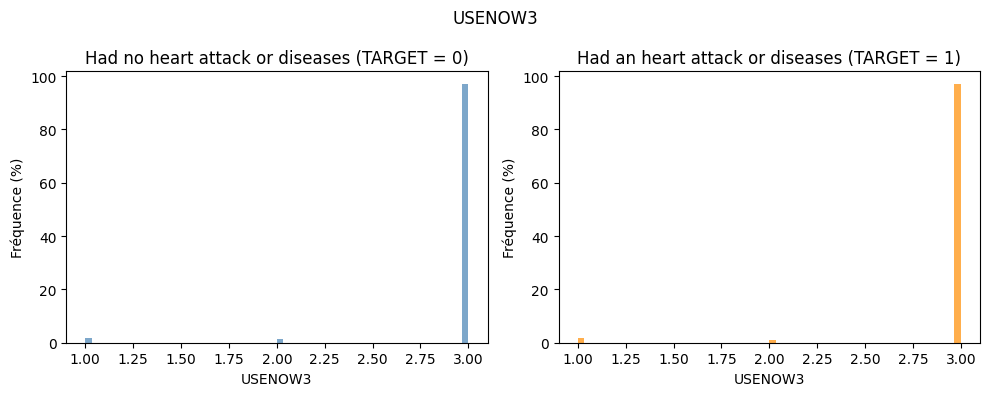

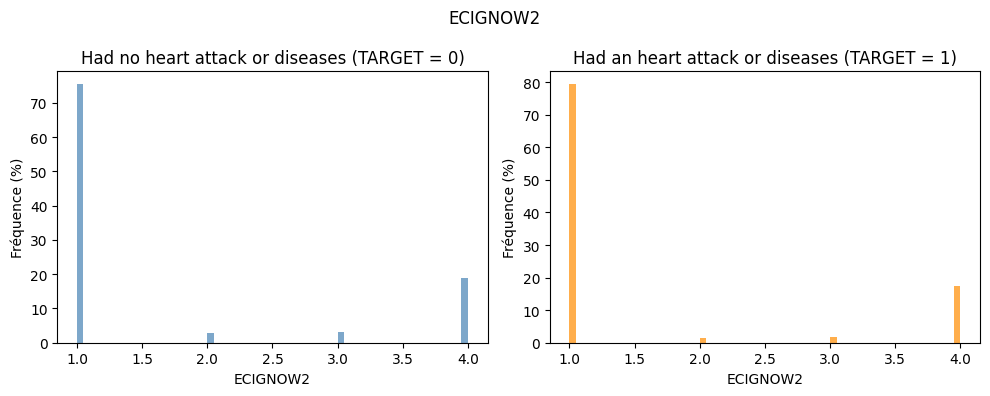

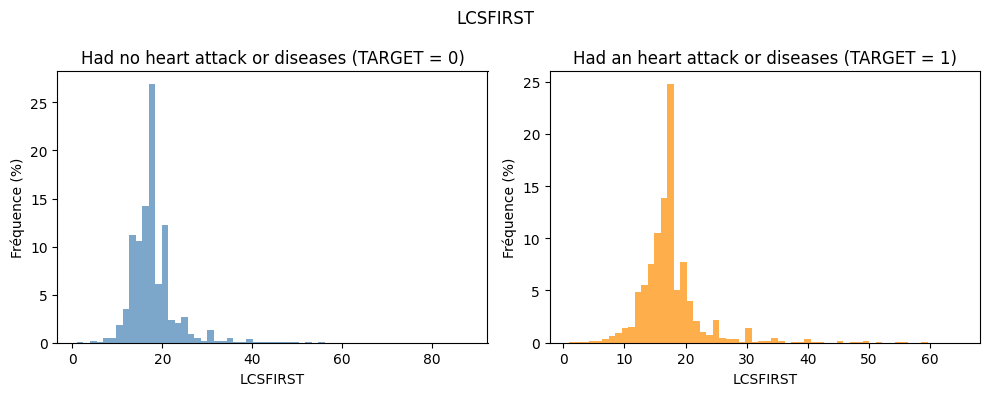

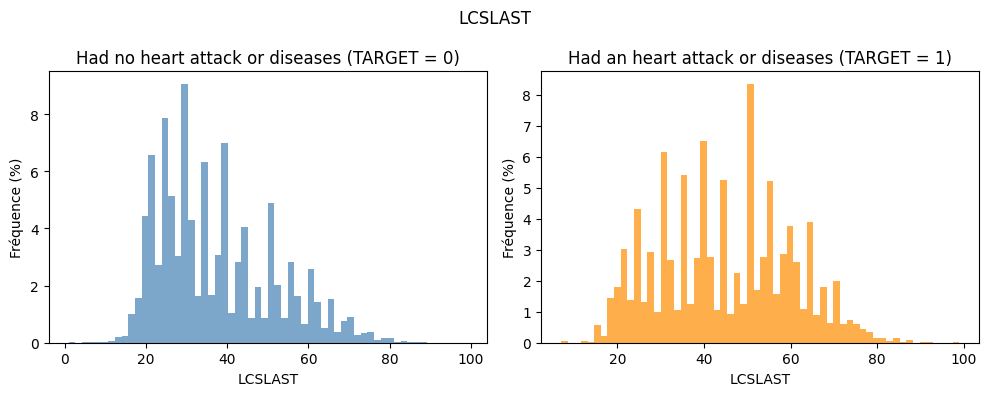

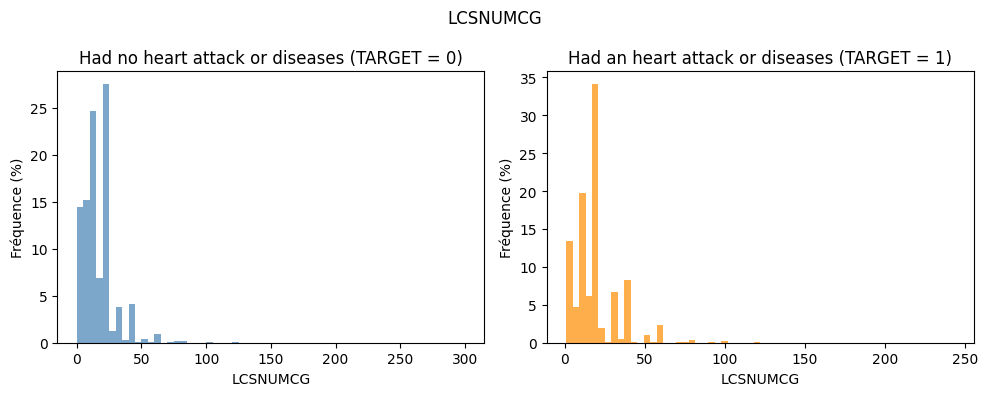

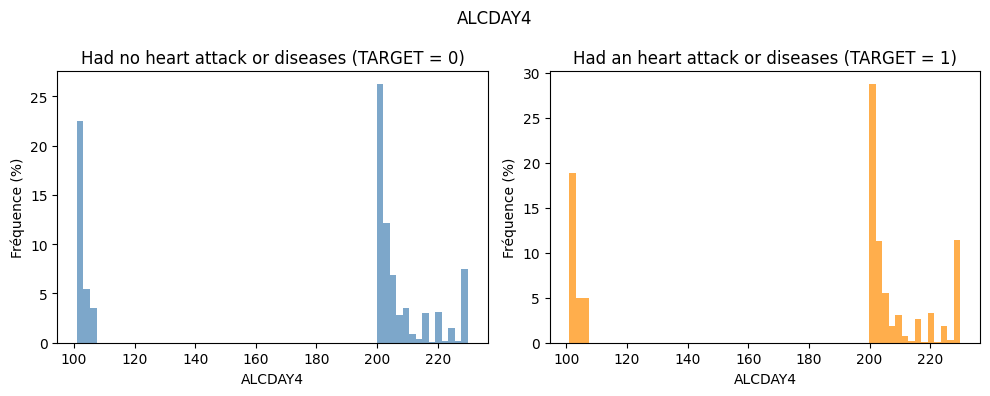

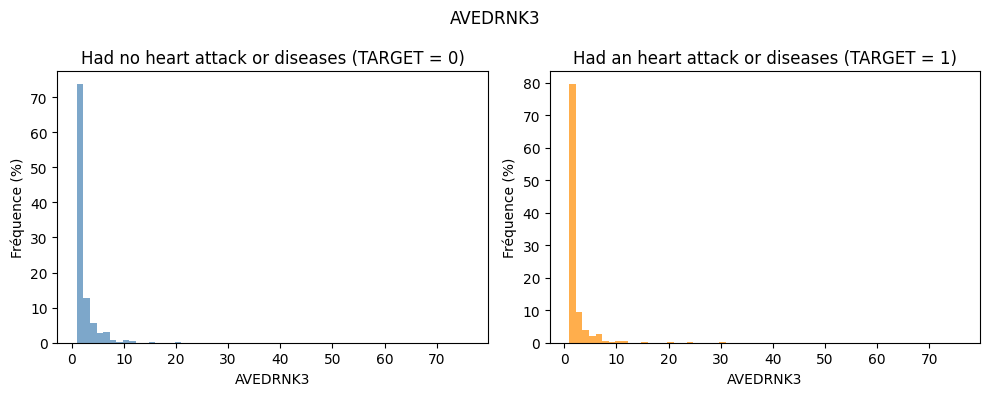

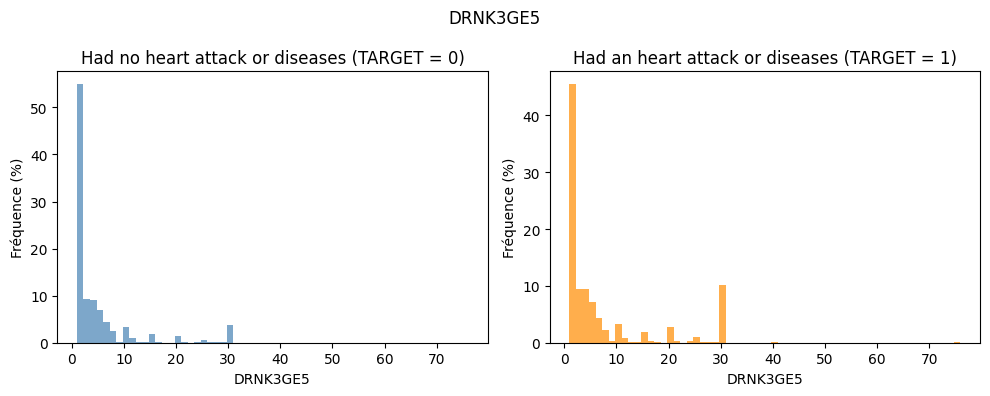

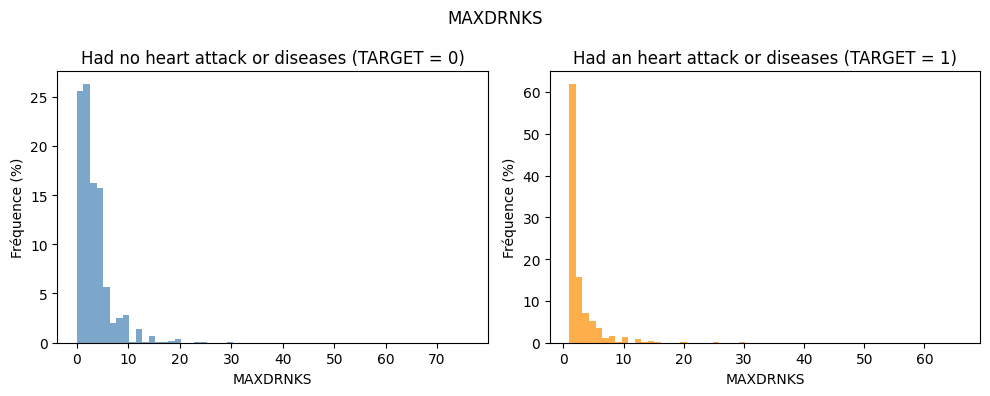

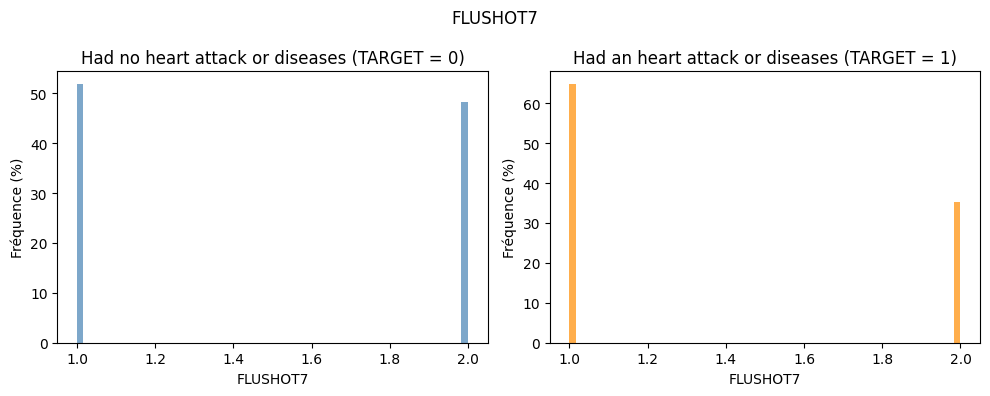

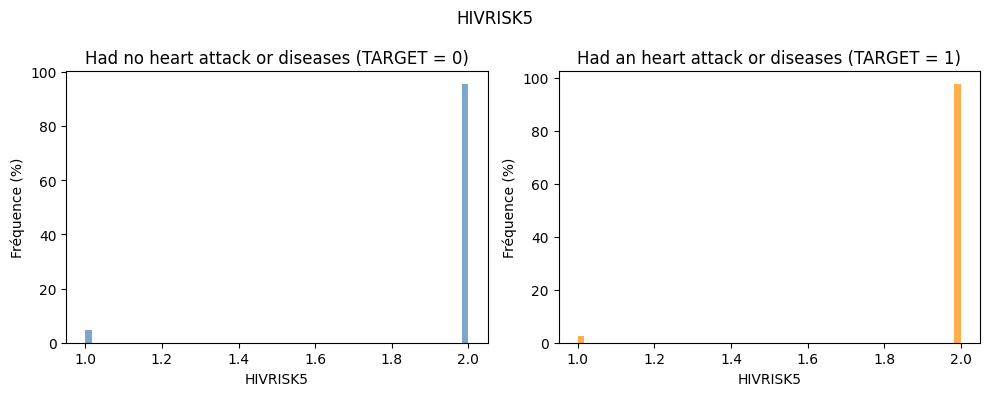

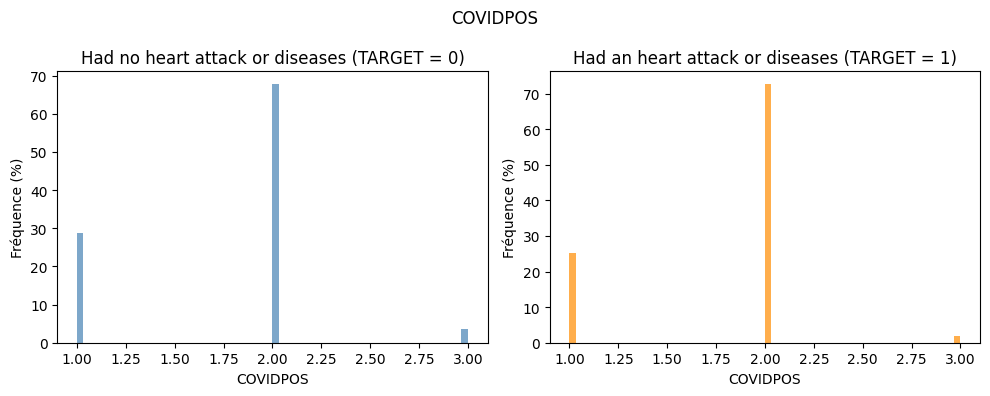

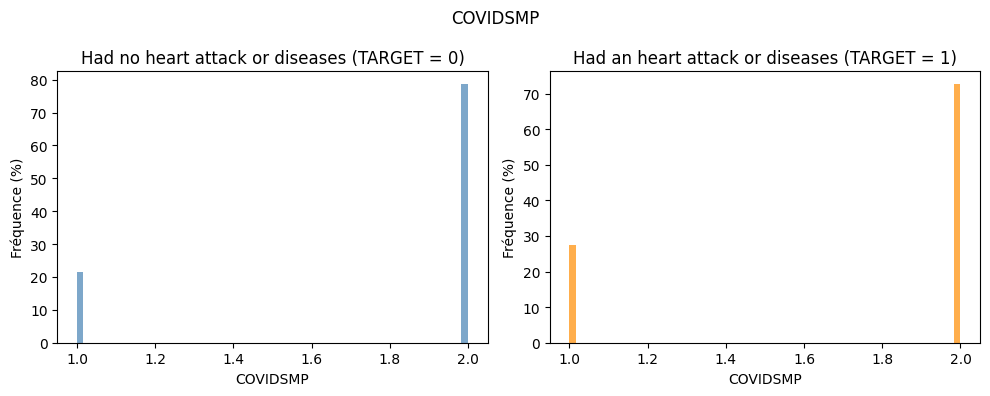

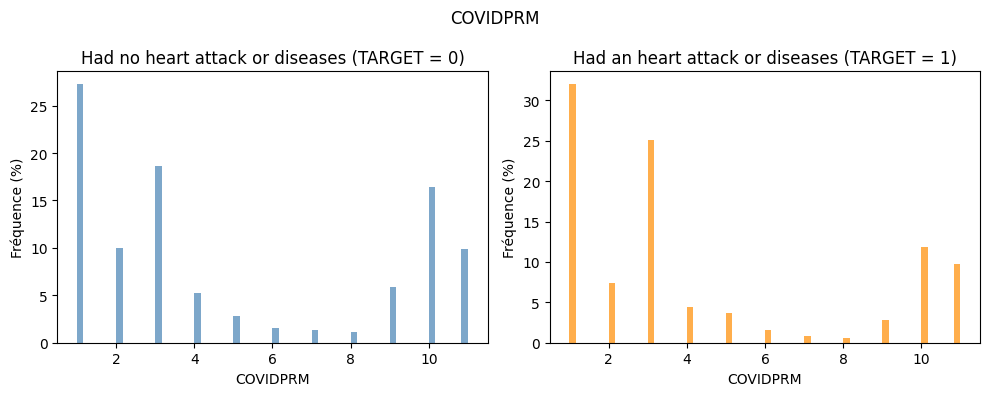

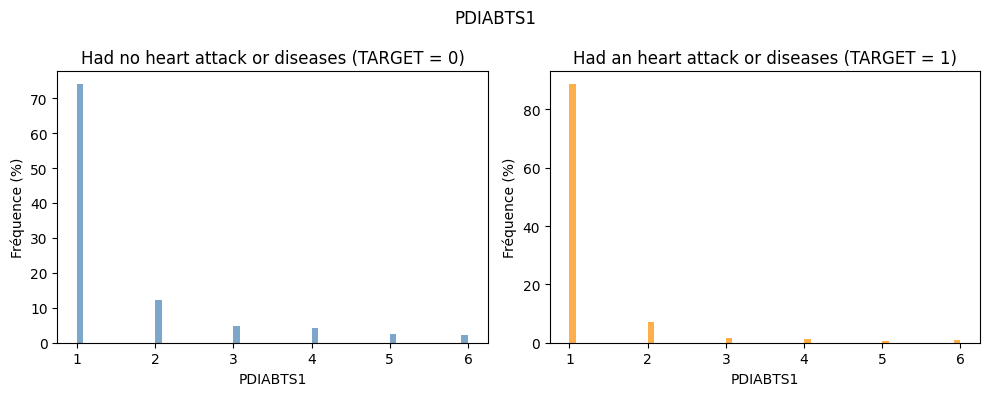

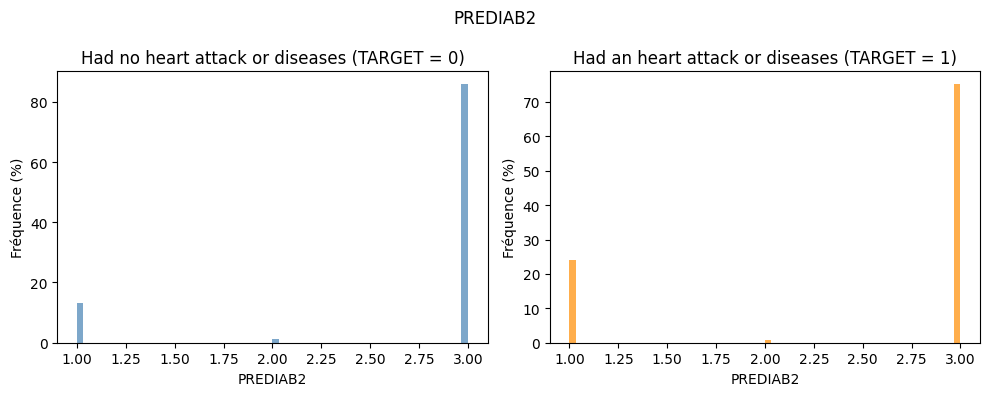

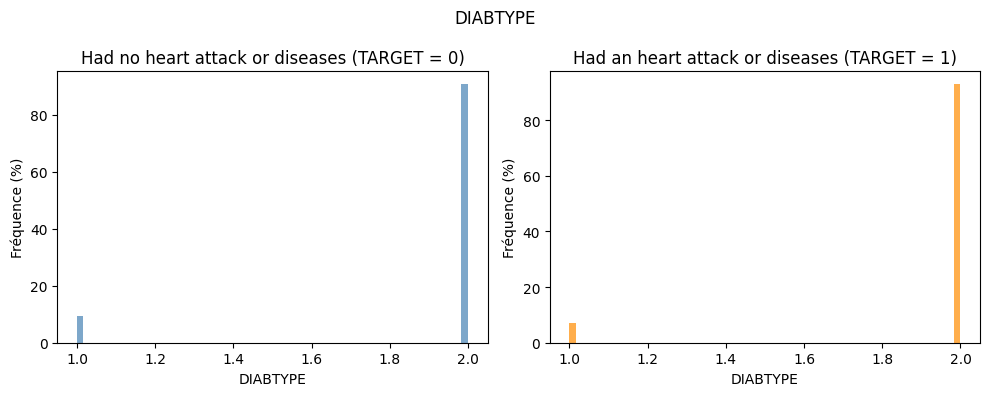

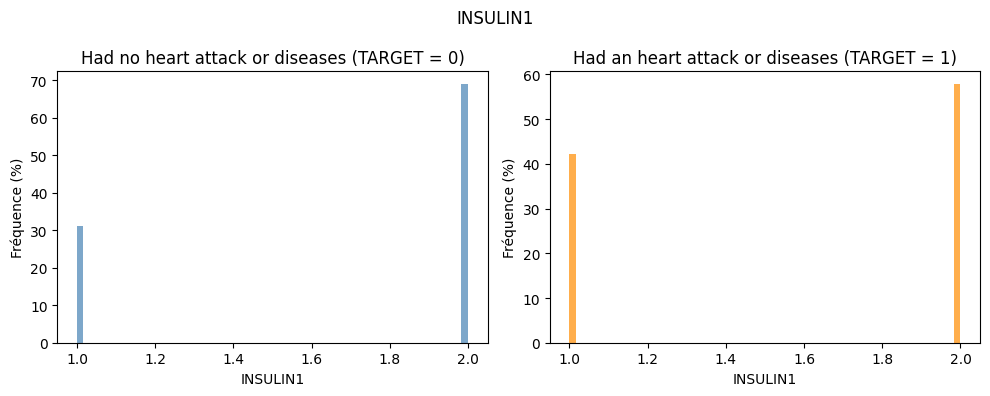

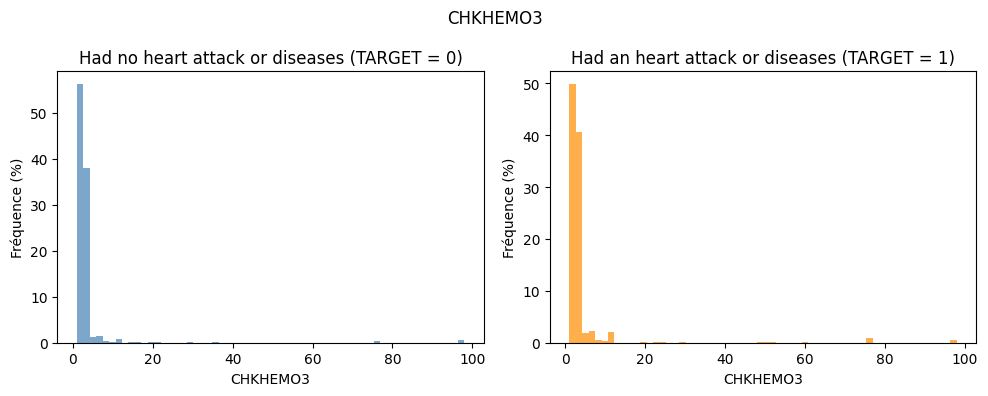

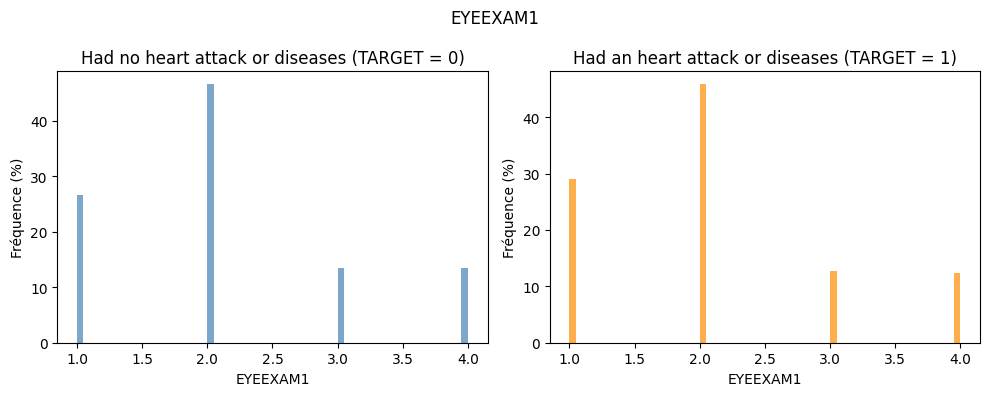

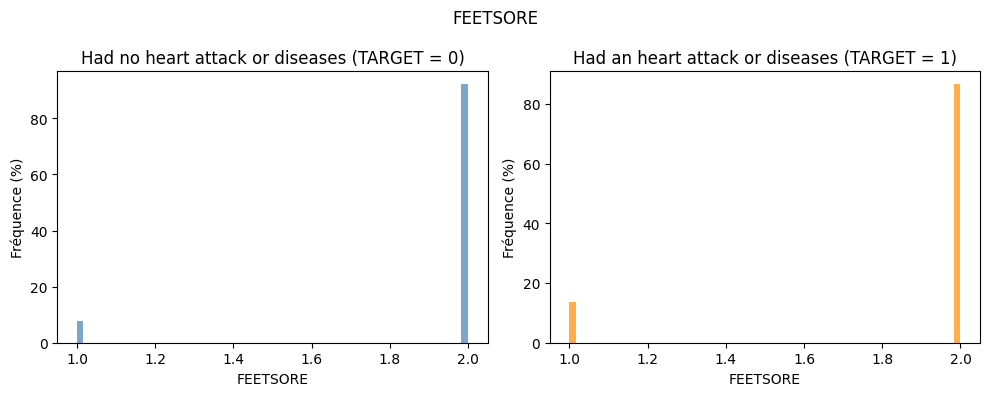

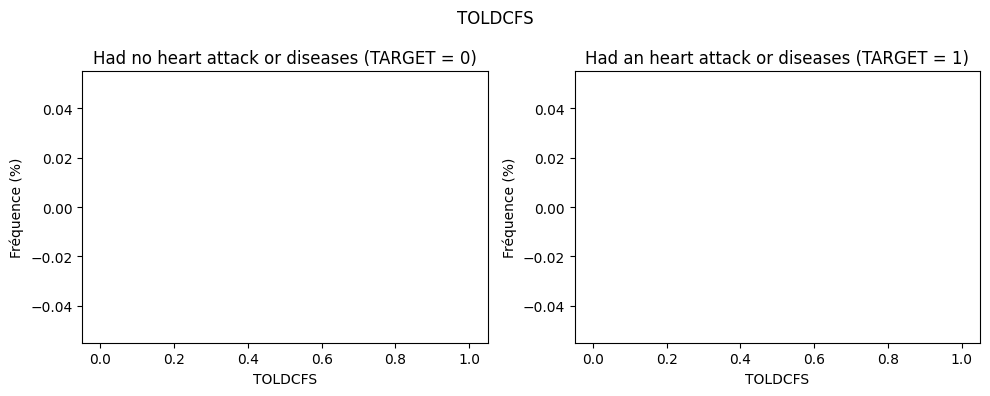

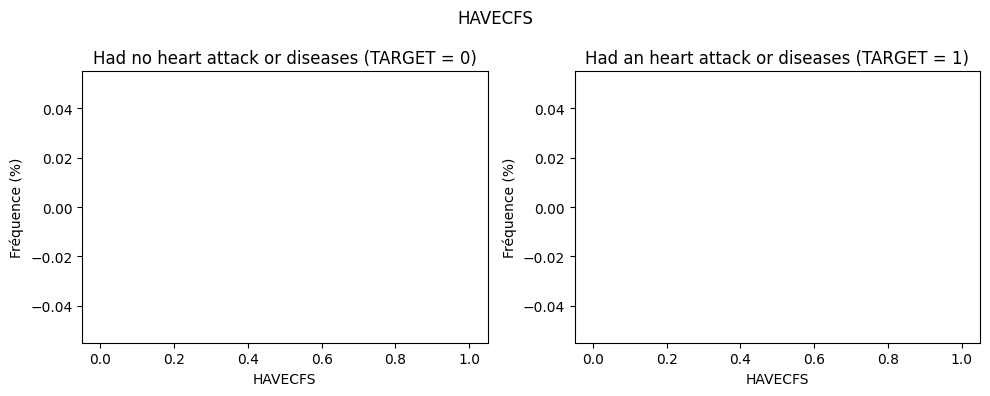

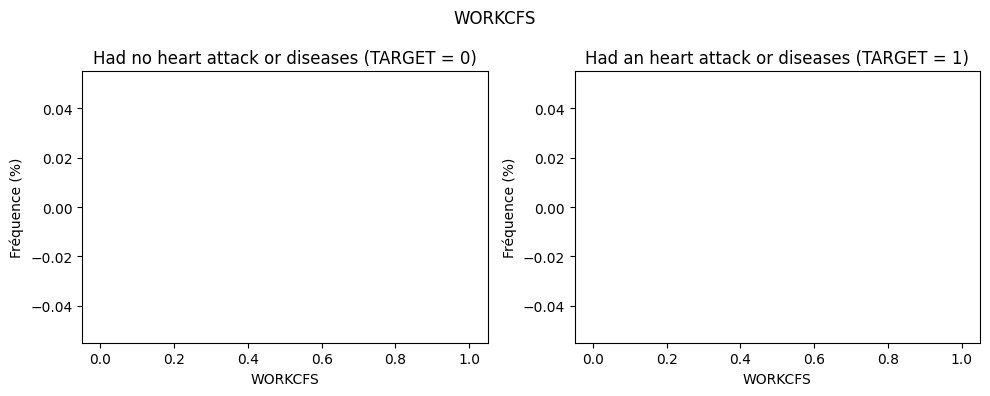

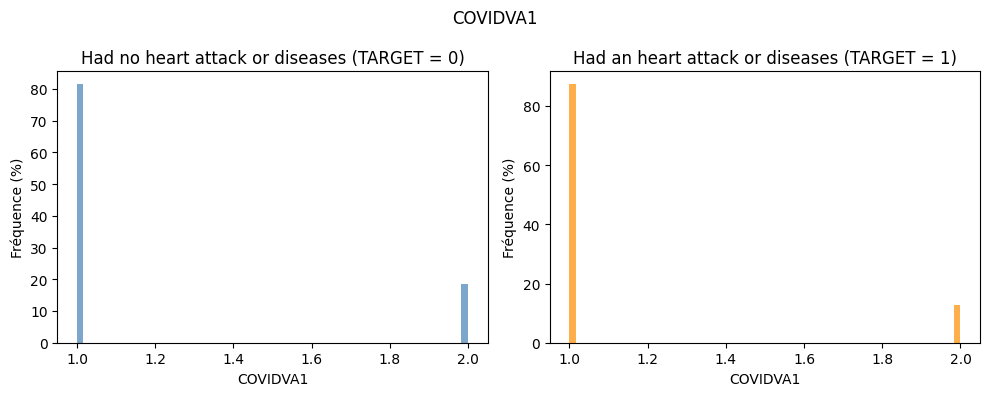

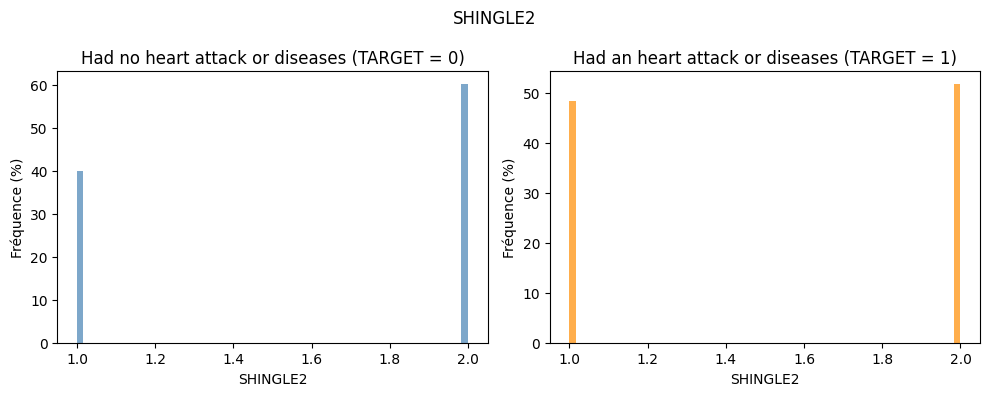

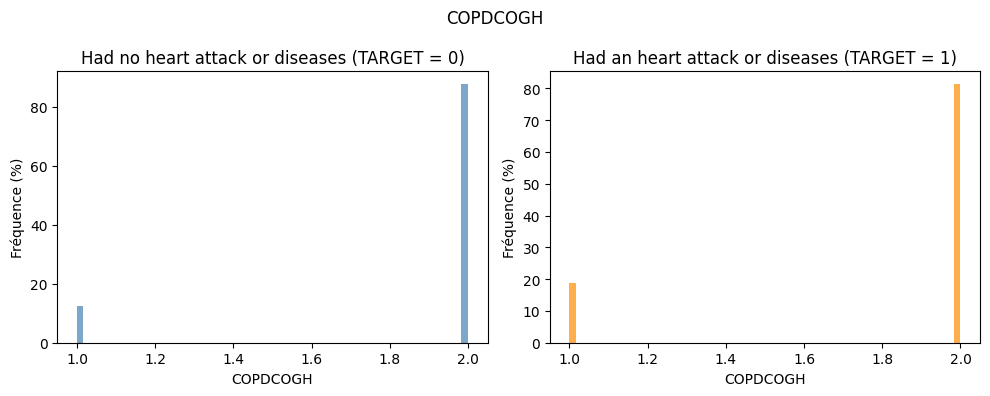

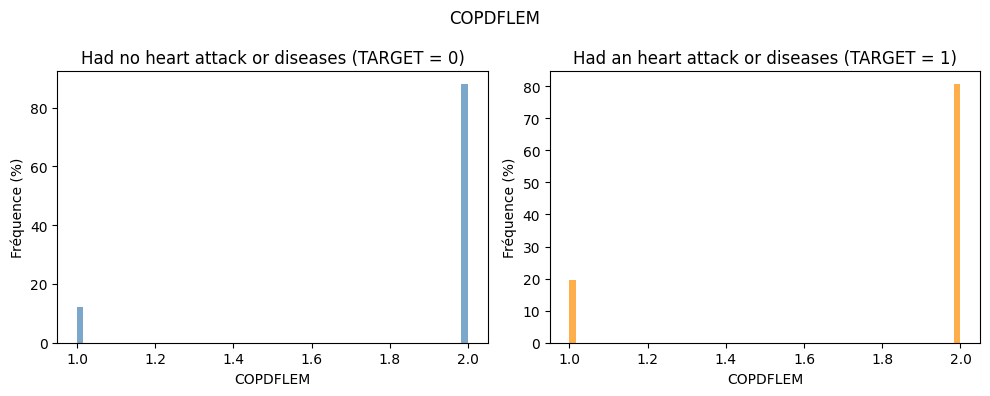

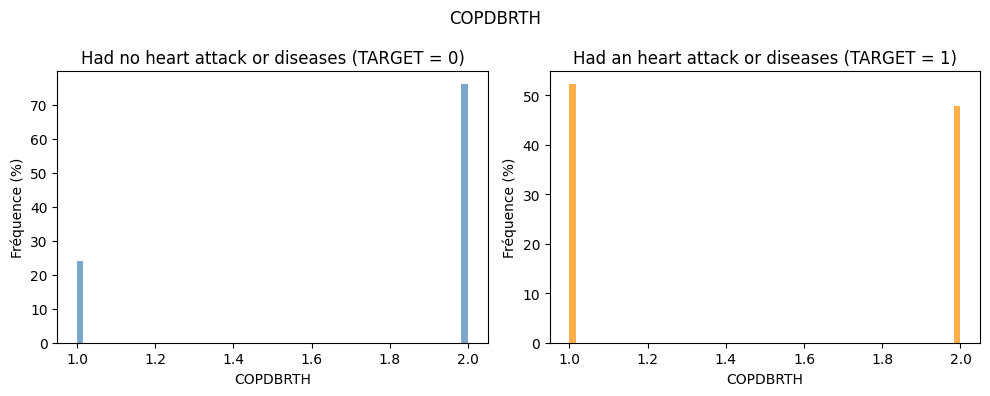

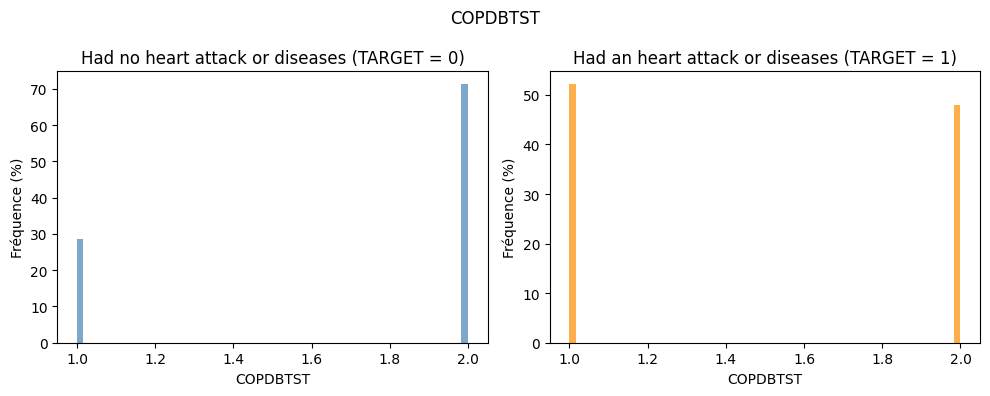

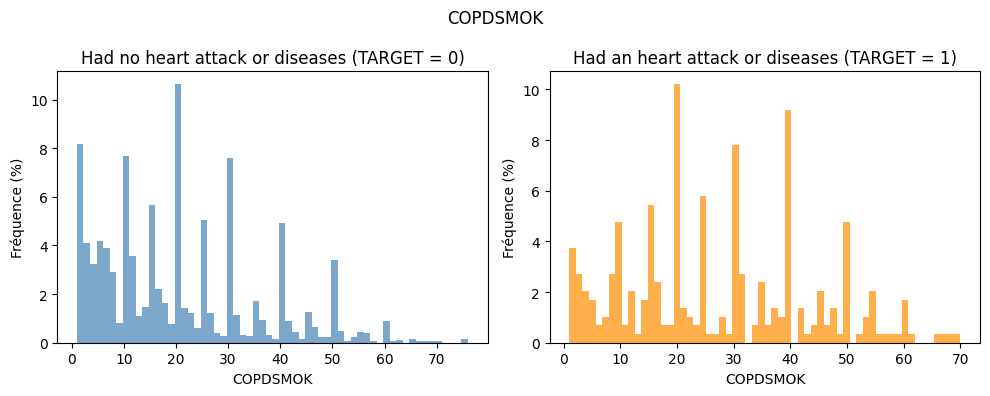

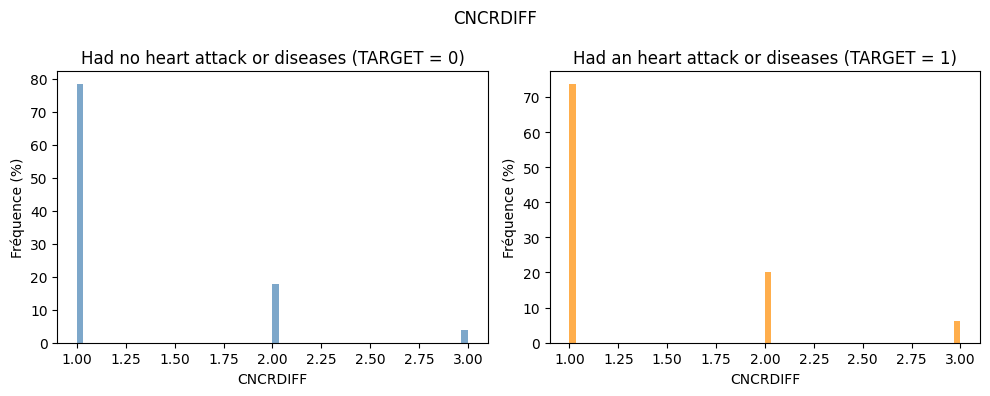

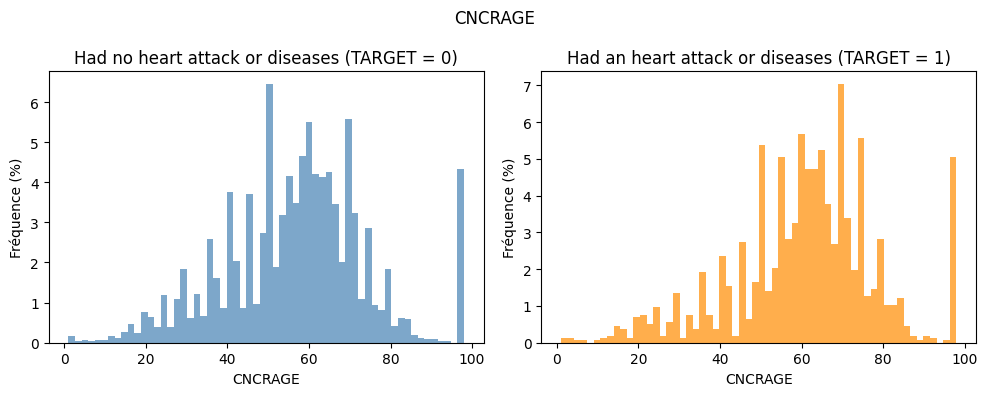

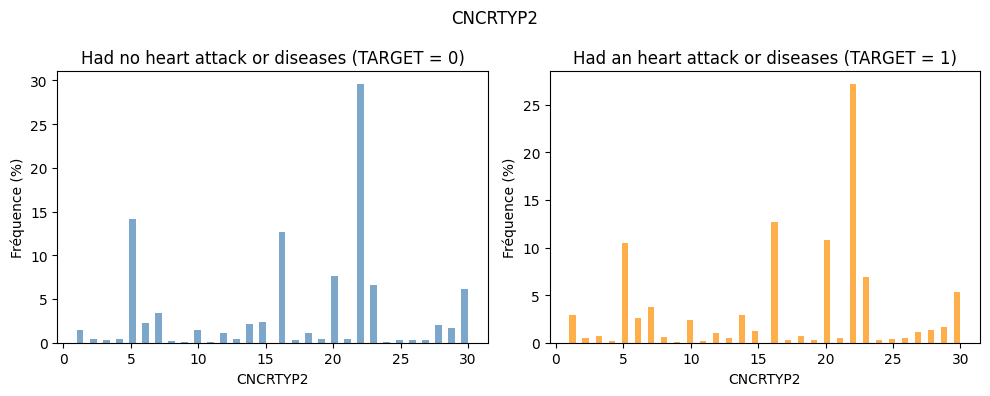

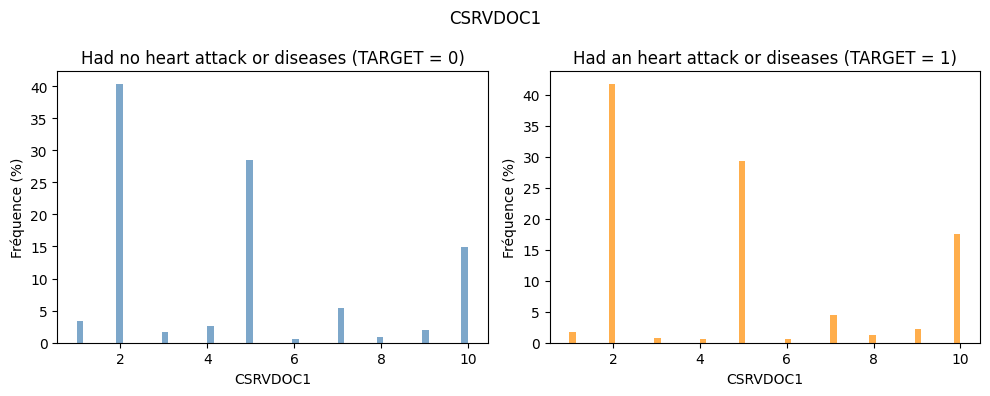

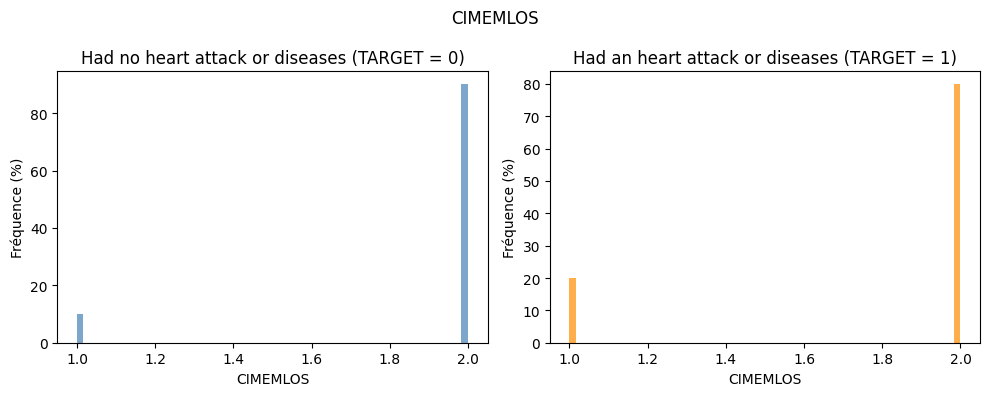

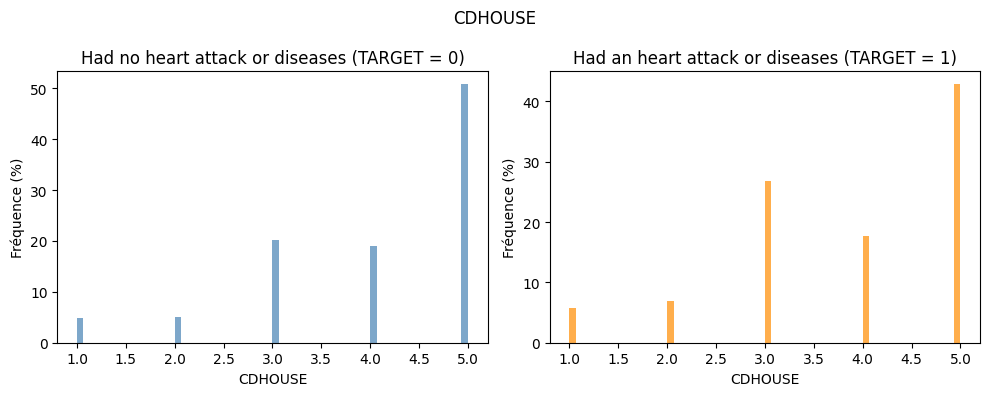

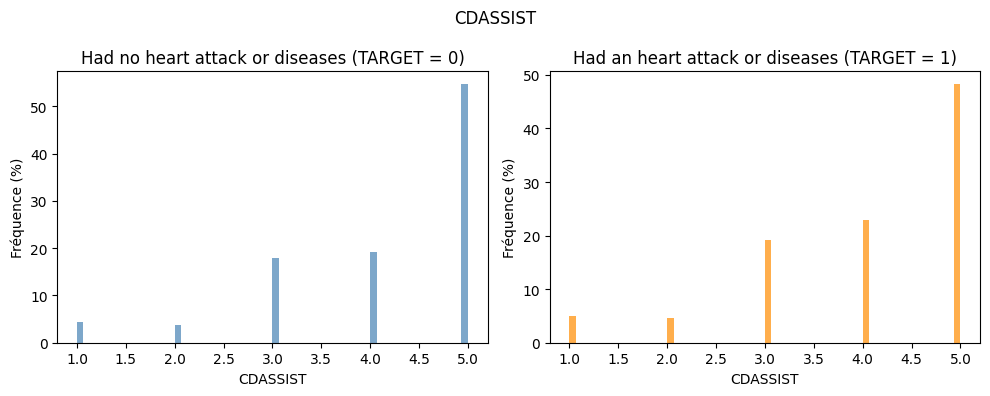

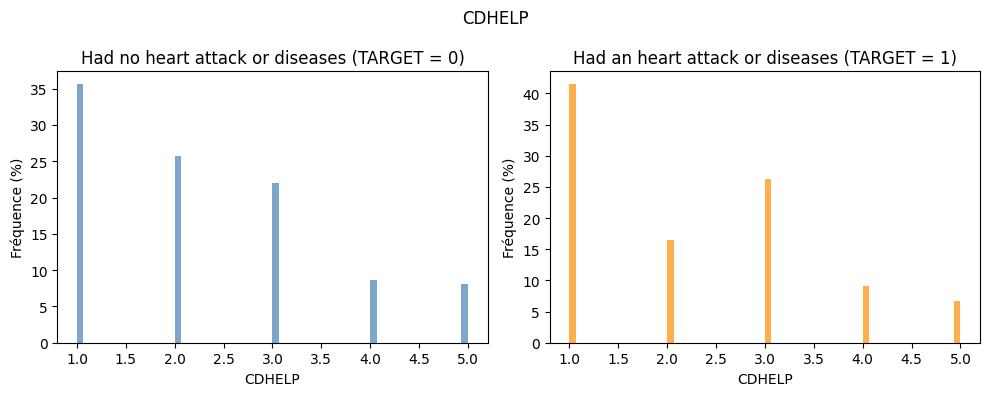

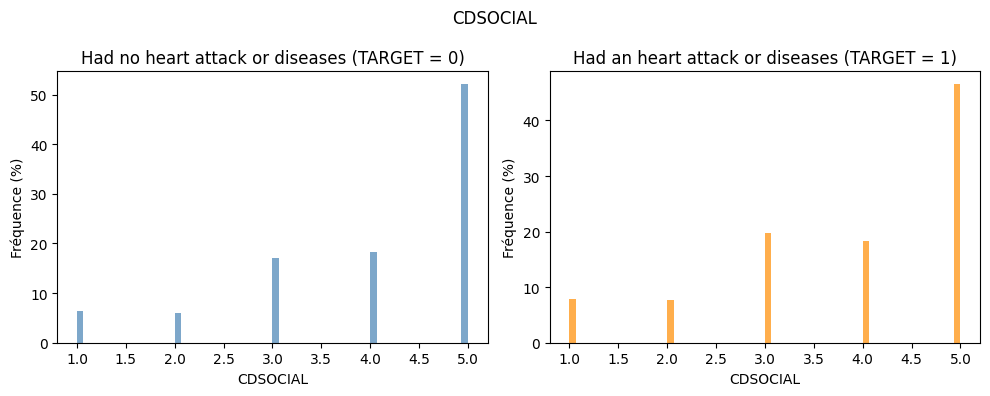

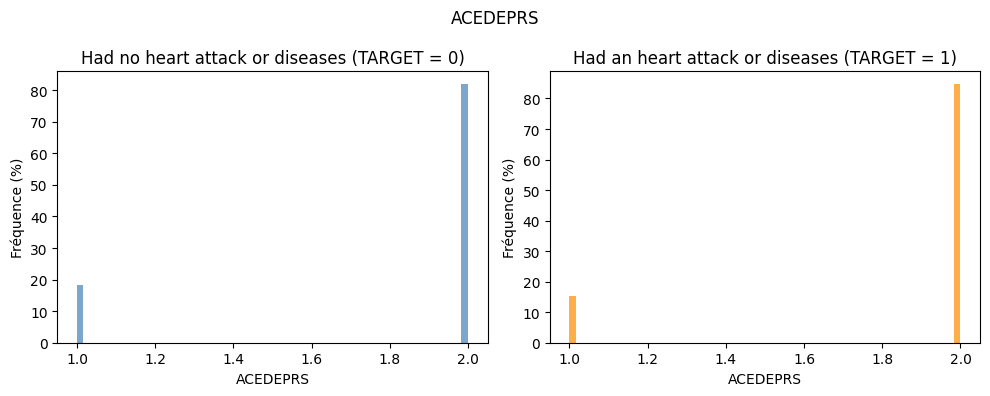

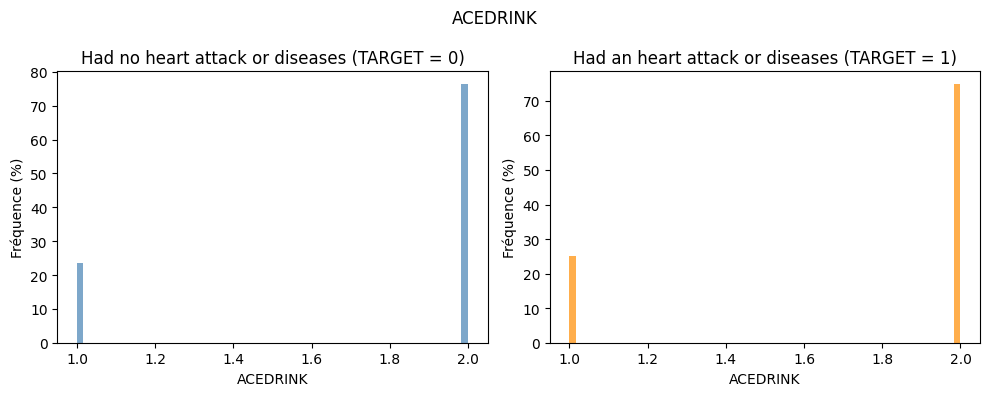

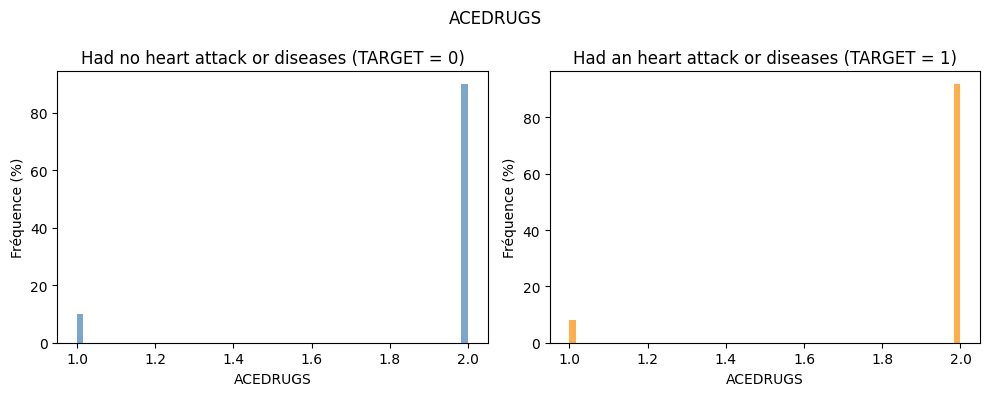

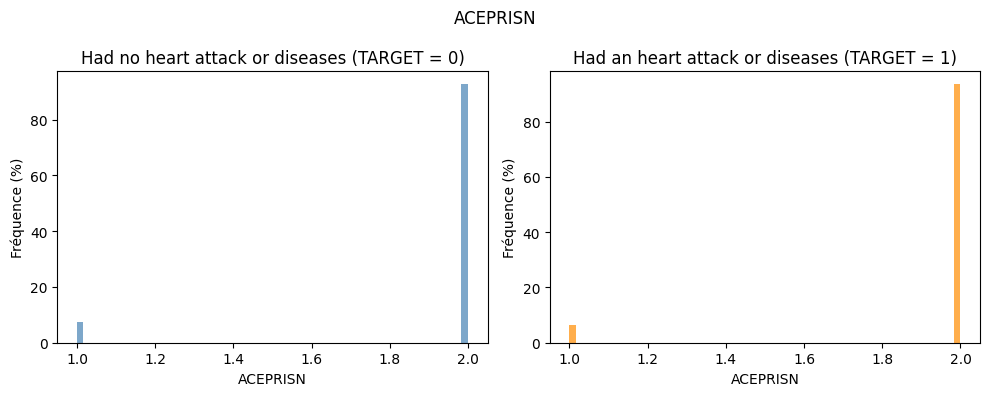

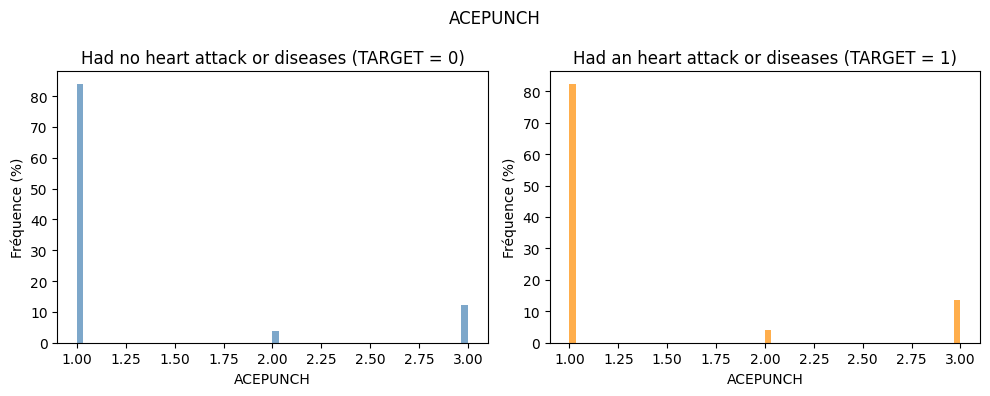

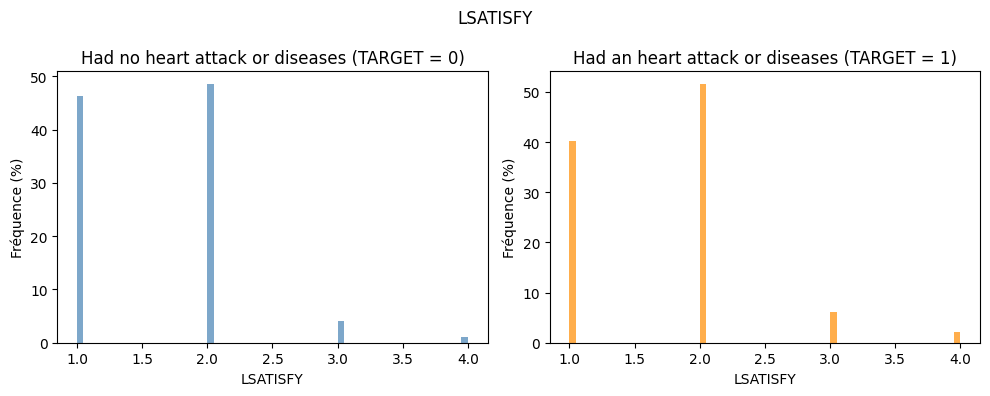

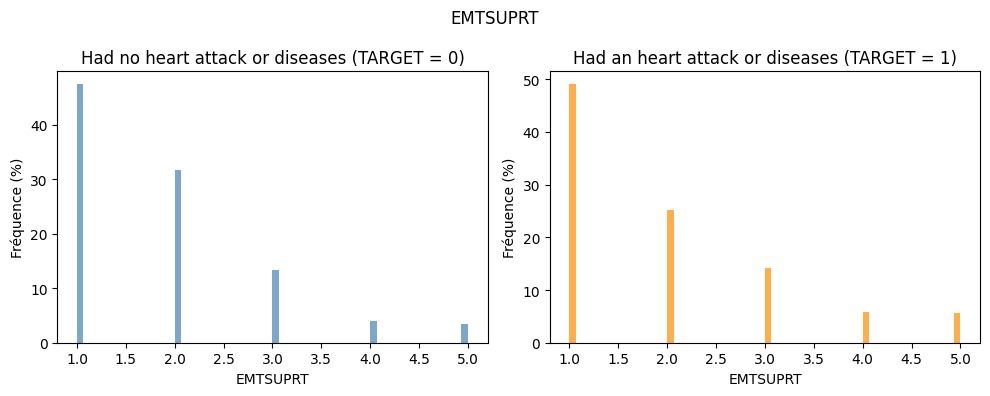

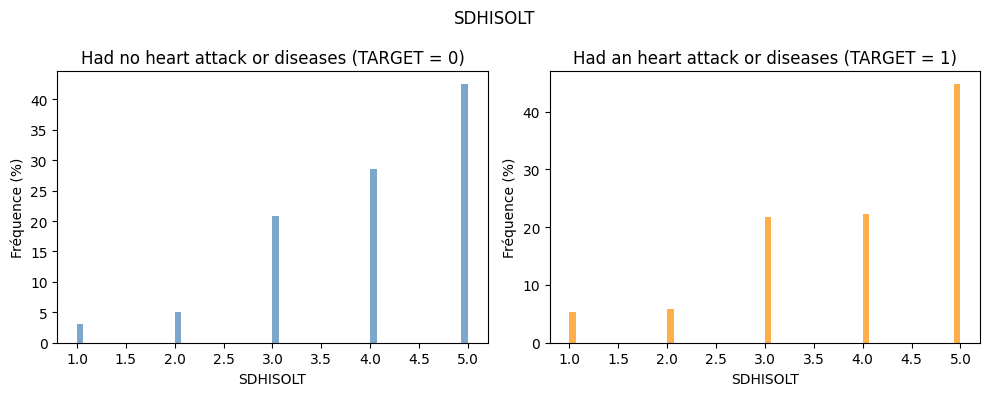

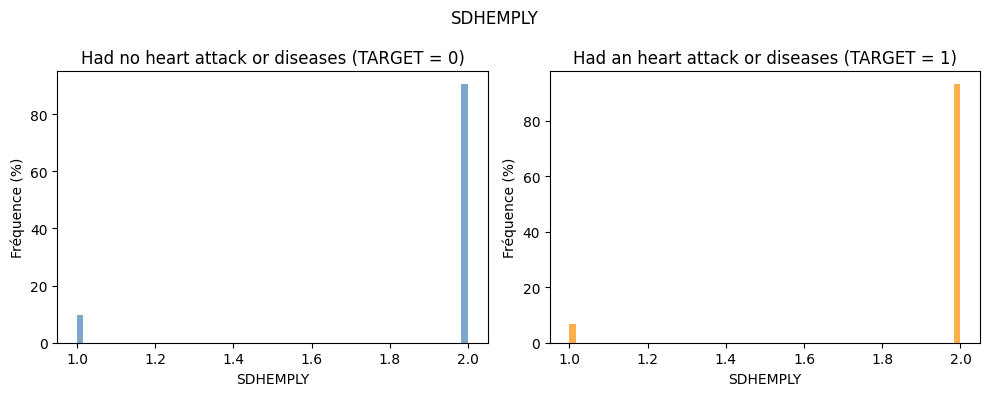

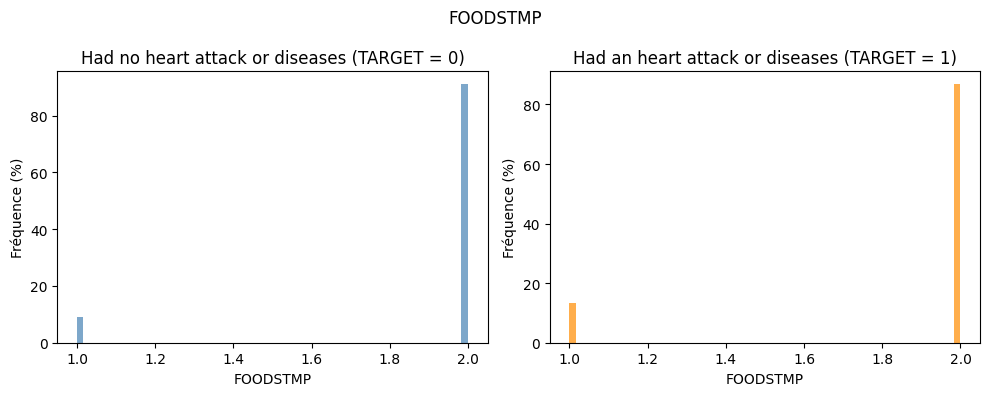

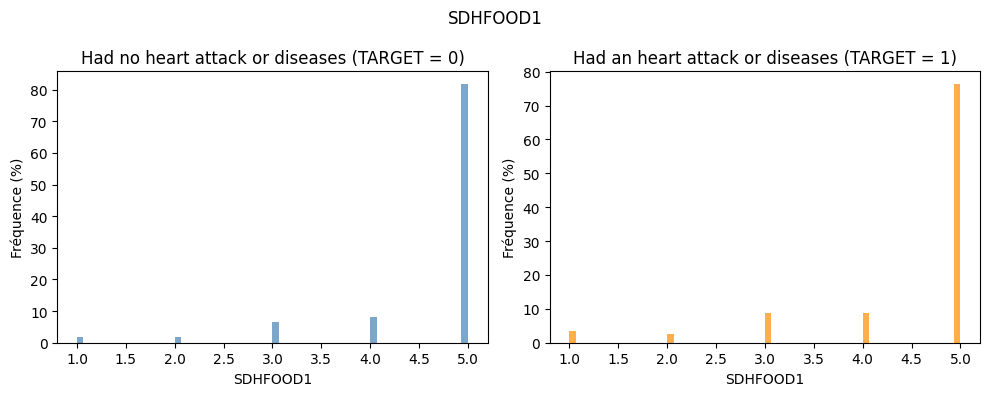

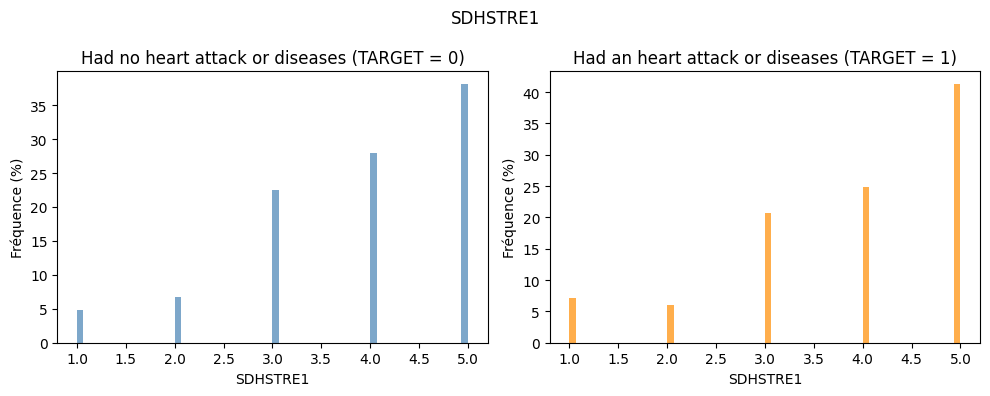

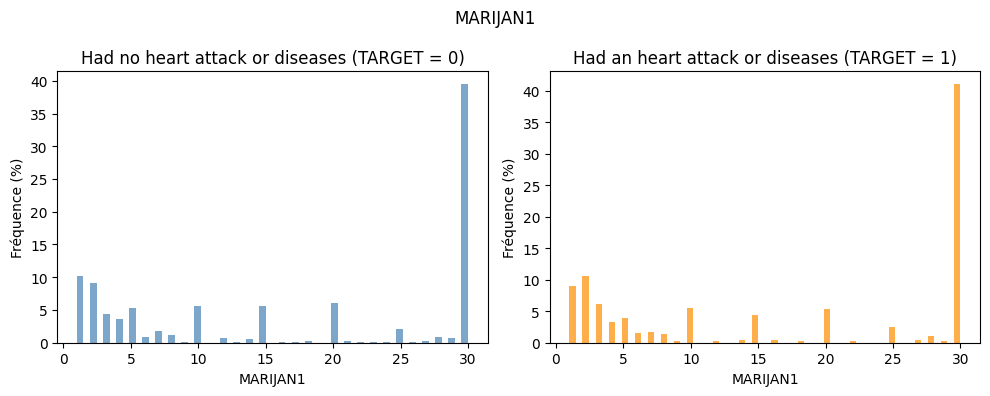

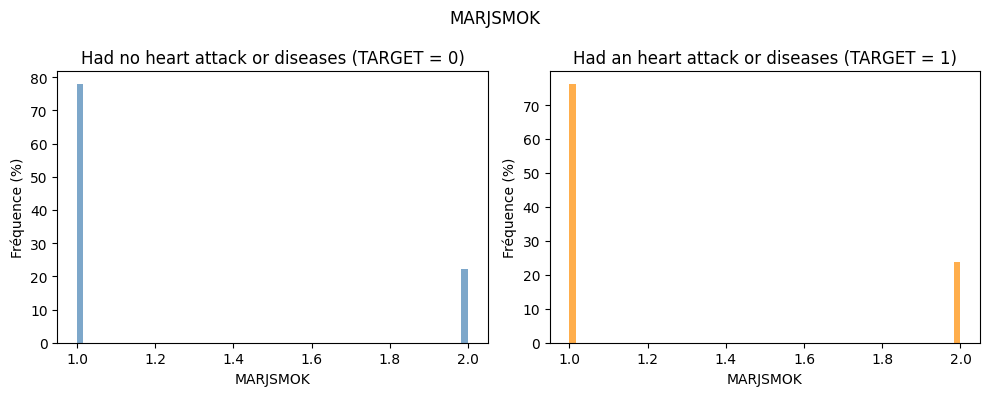

In [60]:
for col in columns_of_interest :
    plot_hist(col, features, target,bins=60)

# PCA

normalisation des données

In [33]:
X = features.fillna(-1).copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

calcul de la PCA

In [34]:
pca = PCA(n_components=min(X_scaled.shape[0], X_scaled.shape[1]))
X_pca = pca.fit_transform(X_scaled)

visualisation de la variance expliquée

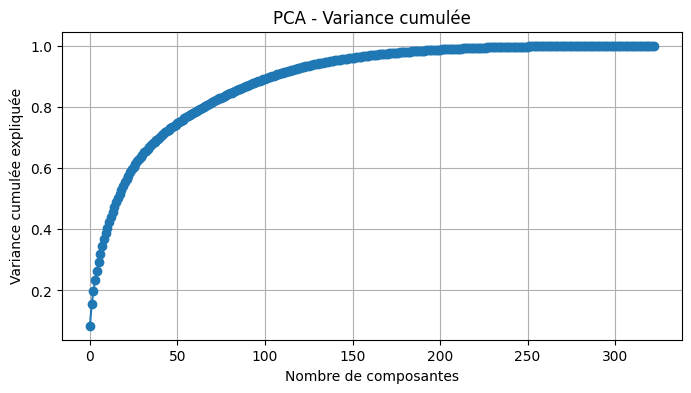

In [35]:
explained_var_ratio = pca.explained_variance_ratio_
cum_var = np.cumsum(explained_var_ratio)

plt.figure(figsize=(8,4))
plt.plot(cum_var, marker='o')
plt.xlabel("Nombre de composantes")
plt.ylabel("Variance cumulée expliquée")
plt.title("PCA - Variance cumulée")
plt.grid(True)
plt.show()


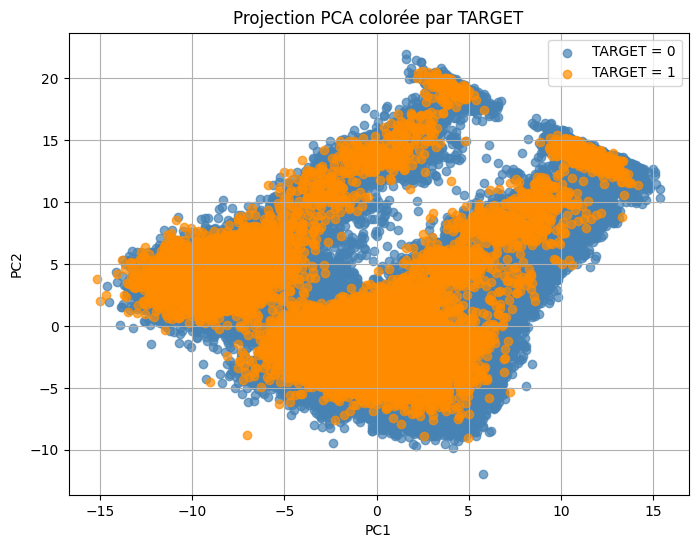

Variance expliquée : [0.08488269 0.07255643] (PC1 + PC2 = 15.7%)


In [40]:
# Scatter plot
plt.figure(figsize=(8,6))
    
for t, color, label in zip([0,1], ["steelblue", "darkorange"], ["TARGET = 0", "TARGET = 1"]):
    mask = (target == t)
    plt.scatter(
        X_pca[mask,0], 
        X_pca[mask,1], 
        alpha=0.7, 
        c=color, 
        label=label
    )
    
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Projection PCA colorée par TARGET")
plt.legend()
plt.grid(True)
plt.show()
    
# Afficher variance expliquée
explained_var_ratio = pca.explained_variance_ratio_
print(f"Variance expliquée : {explained_var_ratio[:2]} (PC1 + PC2 = {sum(explained_var_ratio[:2])*100:.1f}%)")

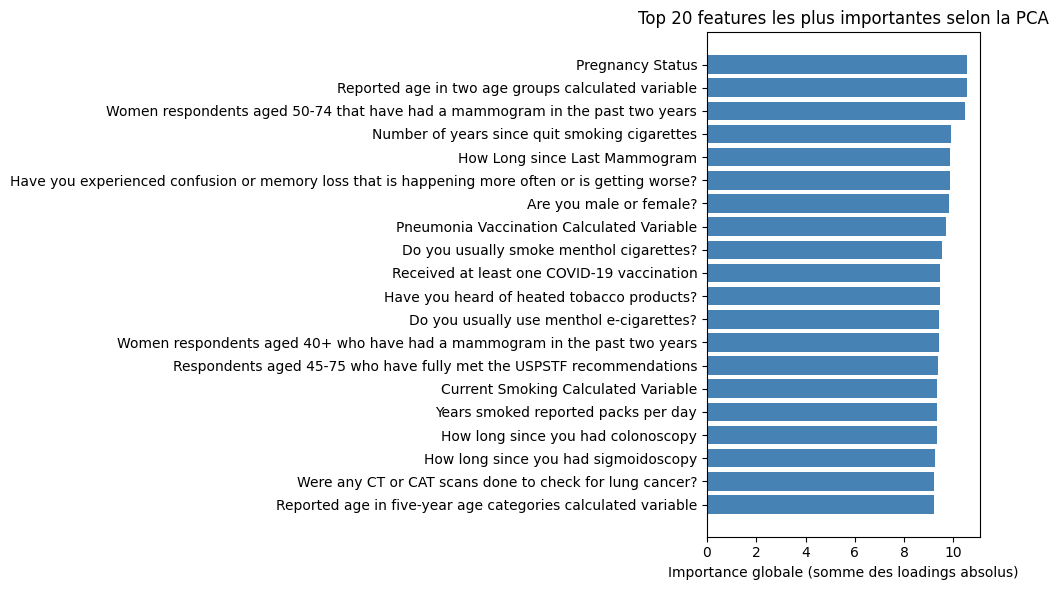

In [45]:
feature_importance = pd.Series(
    np.sum(np.abs(pca.components_), axis=0),
    index=features.columns
)

# Trier et prendre les 20 plus importantes
top_20_features = feature_importance.sort_values(ascending=False).head(20)

top_20_labels = [parsed_dict.get(f, f) for f in top_20_features.index]

plt.figure(figsize=(10,6))
plt.barh(top_20_labels[::-1], top_20_features.values[::-1], color="steelblue")  # inversé pour le meilleur en haut
plt.xlabel("Importance globale (somme des loadings absolus)")
plt.title("Top 20 features les plus importantes selon la PCA")
plt.tight_layout()
plt.show()

Ca casse pas trois pattes à un canard

# Analyse du desequilibre dans les données

In [48]:
n_target_0 = 0
n_target_1 = 0
for t in target : 
    if t :
        n_target_1 += 1
    else :
        n_target_0 += 1
print(f"{n_target_1/(n_target_1+n_target_0)*100} % des sondés ont eu un probeme cardiaque")

8.950666666666667 % des sondés ont eu un probeme cardiaque


Les personnes ayant rencontré un problème cardiaque sont minoritaires. Ils représentent 9% de la population sondée. Afin d'ameliorer notre model il faut le prendre en compte. On peut par exemple quadrupler les données des malades pour l'entrainement.

# Evolution des risques en fonction de divers variables

In [52]:
def plot_risk_by_feature(features, target, feature_name, bins=20, parsed_dict=None, xmin=None, xmax=None):
    """
    Affiche la proportion de TARGET=1 pour chaque intervalle d'une feature continue ou discrète,
    avec possibilité de limiter l'analyse à un intervalle [xmin, xmax].
    
    Args:
        features (pd.DataFrame): dataframe des features
        target (pd.Series): série binaire TARGET
        feature_name (str): nom de la feature à analyser
        bins (int): nombre de bins si feature continue
        parsed_dict (dict, optional): dictionnaire pour titres lisibles
        xmin (float, optional): valeur minimale à inclure
        xmax (float, optional): valeur maximale à inclure
    """
    # Extraire la feature
    data = features[feature_name]
    
    # Ignorer NaN et valeurs invalides
    mask_valid = (~data.isna()) & (data != -1) & (data != 0)
    
    # Appliquer le filtre d'intervalle si fourni
    if xmin is not None:
        mask_valid &= (data >= xmin)
    if xmax is not None:
        mask_valid &= (data <= xmax)
    
    data = data[mask_valid]
    target_clean = target[mask_valid]
    
    # Créer des bins si feature continue
    if pd.api.types.is_numeric_dtype(data):
        bins_edges = np.linspace(data.min(), data.max(), bins + 1)
        data_binned = pd.cut(data, bins=bins_edges, include_lowest=True)
    else:
        data_binned = data
    
    # Calculer proportion TARGET=1 par bin
    risk = target_clean.groupby(data_binned).mean() * 100  # en %
    
    # Plot
    plt.figure(figsize=(10,5))
    plt.plot(risk.index.astype(str), risk.values, marker='o', linestyle='-')
    plt.xticks(rotation=45, ha='right')
    
    ylabel = "Proportion TARGET=1 (%)"
    xlabel = parsed_dict.get(feature_name, feature_name) if parsed_dict else feature_name
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f"Évolution du risque selon {xlabel}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


/var/folders/hf/cz9pm8_16vs_zz16xs5lw1xc0000gn/T/ipykernel_6956/712118207.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk = target_clean.groupby(data_binned).mean() * 100  # en %


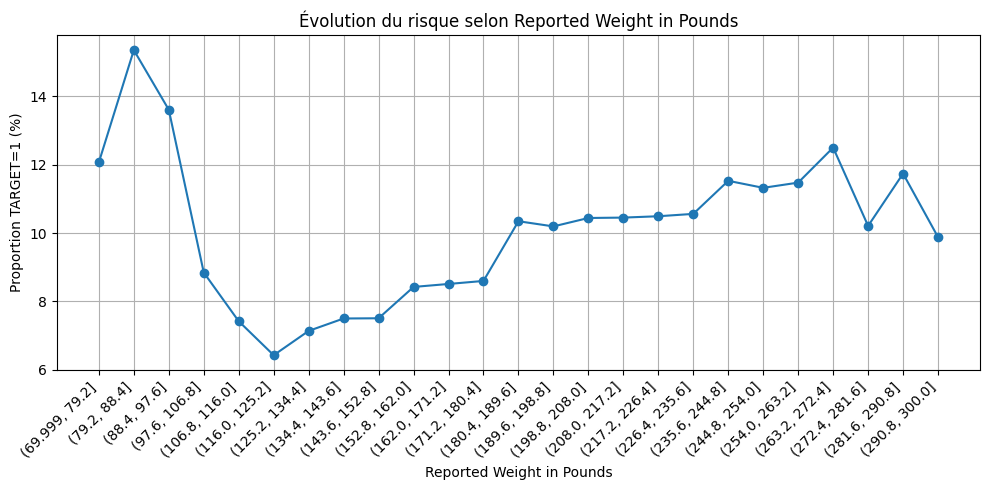

/var/folders/hf/cz9pm8_16vs_zz16xs5lw1xc0000gn/T/ipykernel_6956/712118207.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk = target_clean.groupby(data_binned).mean() * 100  # en %


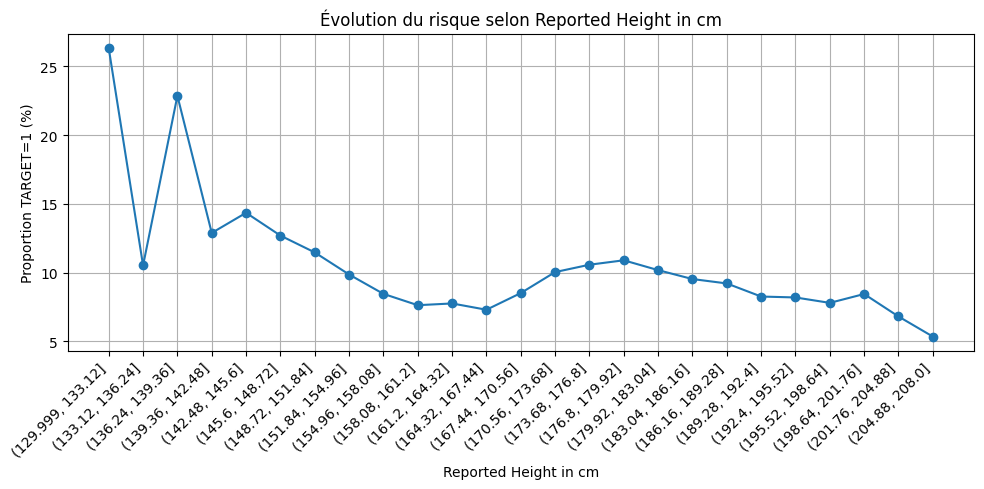

In [55]:
# Ne tracer que les poids entre 70 et 400 pounds
plot_risk_by_feature(features, target, "WEIGHT2", bins=25, parsed_dict=parsed_dict, xmin=70, xmax=300)

# Ne tracer que les tailles entre 130 et 210 cm
plot_risk_by_feature(features, target, "HEIGHT3", bins=25, parsed_dict=parsed_dict, xmin=130, xmax=210)

In [56]:
def scatter_by_target(features, target, feature_x, feature_y, parsed_dict=None,
                      valid_mask=None, figsize=(12,5), alpha=0.5):
    """
    Scatter plots de feature_y en fonction de feature_x, séparé par TARGET.
    
    Args:
        features (pd.DataFrame): dataframe des features
        target (pd.Series): série TARGET binaire
        feature_x (str): feature pour l'axe X
        feature_y (str): feature pour l'axe Y
        parsed_dict (dict, optional): labels lisibles
        valid_mask (pd.Series, optional): masque booléen pour filtrer les données invalides
        figsize (tuple): taille de la figure
        alpha (float): transparence des points
    """
    x = features[feature_x]
    y = features[feature_y]
    
    if valid_mask is None:
        # Masque par défaut : ignorer NaN et valeurs <=0
        valid_mask = (~x.isna()) & (~y.isna()) & (x > 0) & (y > 0)
    
    x = x[valid_mask]
    y = y[valid_mask]
    target_clean = target[valid_mask]
    
    # Séparer selon TARGET
    x_0 = x[target_clean == 0]
    y_0 = y[target_clean == 0]
    
    x_1 = x[target_clean == 1]
    y_1 = y[target_clean == 1]
    
    # Création des plots
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    axes[0].scatter(x_0, y_0, alpha=alpha, color="steelblue")
    axes[0].set_xlabel(parsed_dict.get(feature_x, feature_x) if parsed_dict else feature_x)
    axes[0].set_ylabel(parsed_dict.get(feature_y, feature_y) if parsed_dict else feature_y)
    axes[0].set_title("TARGET = 0")
    axes[0].grid(True)
    
    axes[1].scatter(x_1, y_1, alpha=alpha, color="darkorange")
    axes[1].set_xlabel(parsed_dict.get(feature_x, feature_x) if parsed_dict else feature_x)
    axes[1].set_ylabel(parsed_dict.get(feature_y, feature_y) if parsed_dict else feature_y)
    axes[1].set_title("TARGET = 1")
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()


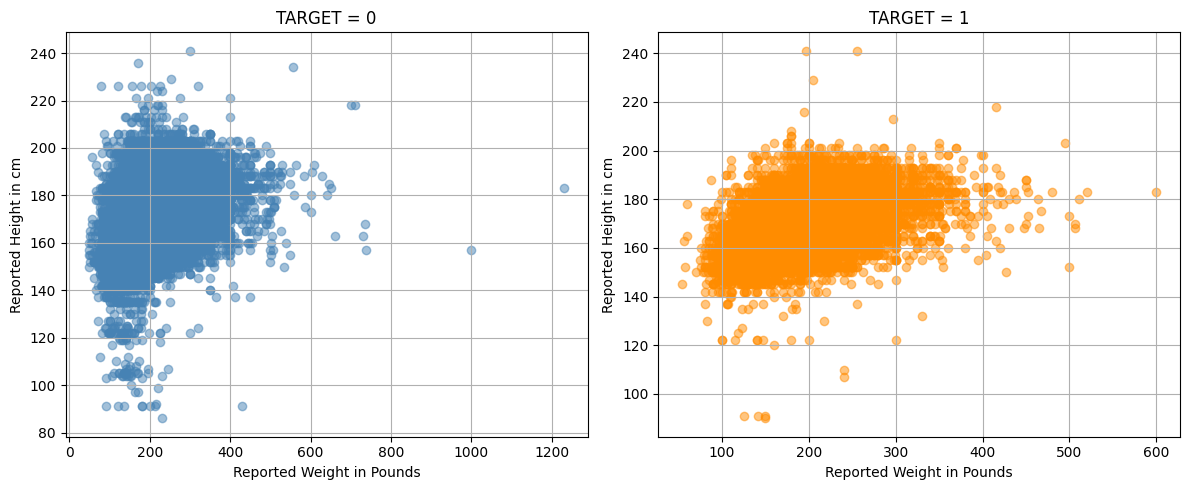

In [59]:
# Scatter poids vs taille
scatter_by_target(features, target, "WEIGHT2", "HEIGHT3", parsed_dict=parsed_dict)

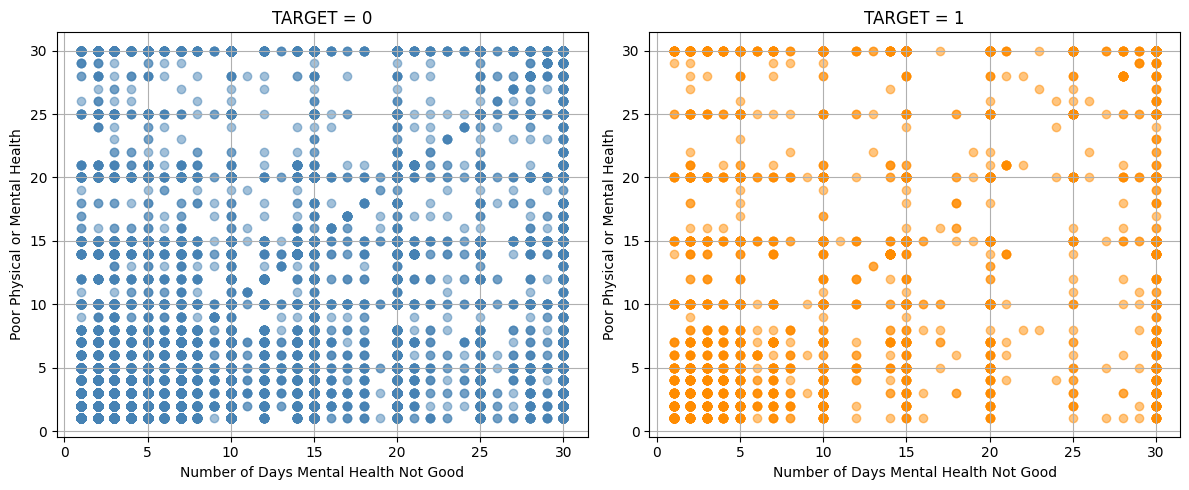

In [61]:
scatter_by_target(features, target, "MENTHLTH", "POORHLTH", parsed_dict=parsed_dict)

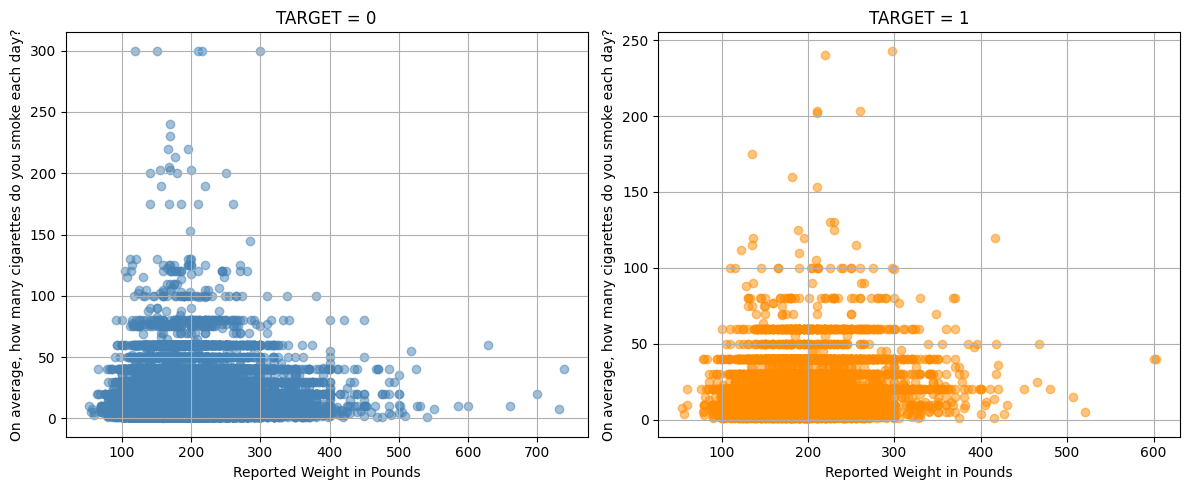

In [63]:
scatter_by_target(features, target, "WEIGHT2", "LCSNUMCG", parsed_dict=parsed_dict)

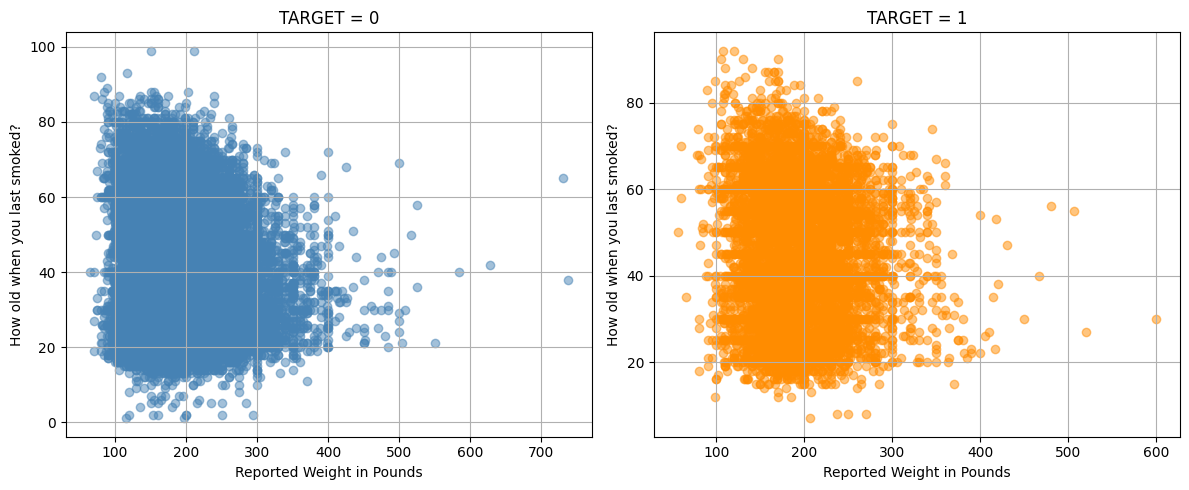

In [64]:
scatter_by_target(features, target, "WEIGHT2", "LCSLAST", parsed_dict=parsed_dict)

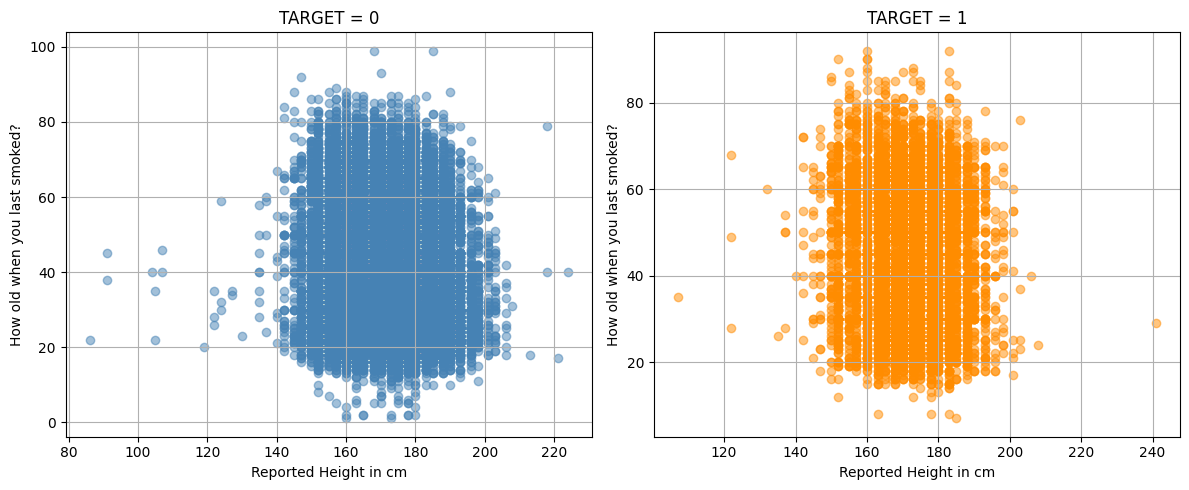

In [65]:
scatter_by_target(features, target, "HEIGHT3", "LCSLAST", parsed_dict=parsed_dict)

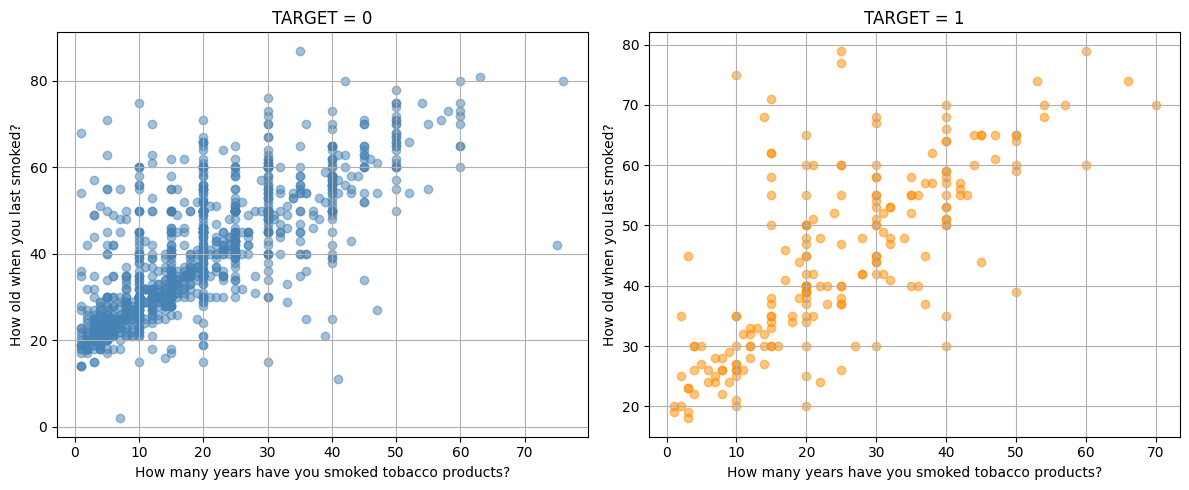

In [70]:
scatter_by_target(features, target, "COPDSMOK", "LCSLAST", parsed_dict=parsed_dict)

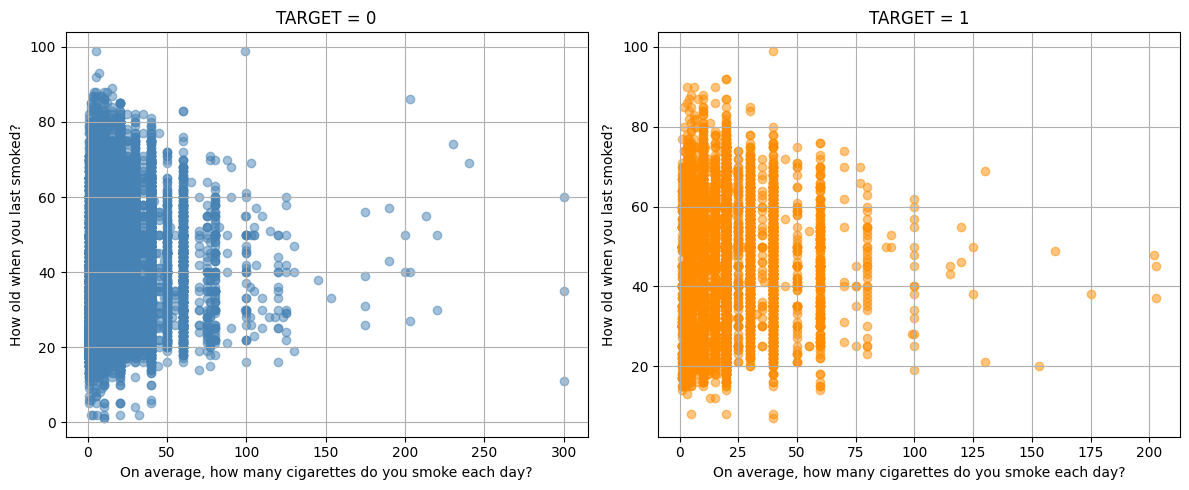

In [71]:
scatter_by_target(features, target, "LCSNUMCG", "LCSLAST", parsed_dict=parsed_dict)